In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

from tqdm.auto import tqdm

from scipy import stats

plt.style.use('ggplot')

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from scipy.stats import kruskal
import scikit_posthocs as sp

In [2]:
sns.set(rc={'figure.figsize': (16,6)}, style='whitegrid') 

In [3]:

#          Согласно предоставленной информации, в эксперименте приняло участие три группы: тестовая (test),
#   контрольная 1 (control_1) и контрольная 2 (control_2). Судя по всему, имеем дело с классическим вариантом A/A/B теста.
#          Дополнительная контрольная А-ветка является страховкой (например, если в компании кто-то параллельно проводит 
#   эксперимент с той же целевой метрикой или чтобы убедиться в качестве сплитования). Встречается точка зрения,
#   что A/A/B тест - это компромиссный лайт-вариант процесса последовательного проведения A/A теста, а затем A/B - теста.
#          В  A/A/B тестах мы хотим принимать гипотезу H(0) в паре A1/A2 и отвергать H(0) на этапе A1+A2/B.


In [4]:

#   Предполагаемые:
#         Цель эксперимента: повысить выручку за счет изменения для новых пользователей из нескольких стран стоимости
#                            премиум-подписки при покупке через две новые платежные системы.  
#         Метрики: Retention, ARPPU, Active Users.
#         Гипотеза: ожидаем, что за счет изменения стоимости премиум-подписки будут получены достоверно значимые различия 
#                   по выручке между группами A1+A2/B.


In [5]:
#                                 1. ПРЕДПОДГОТОВКА ДАННЫХ, ПРЕДВАРИТЕЛЬНЫЙ АНАЛИЗ

In [6]:
users_test = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/users_test.csv', encoding='Windows-1251', sep=';')

In [7]:
transactions_test = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/transactions_test.csv', encoding='Windows-1251', sep=';', parse_dates=['joined_at', 'paid_at'])

In [8]:
users_control_1 = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/users_control_1.csv', encoding='Windows-1251', sep=';')

In [9]:
transactions_control_1 = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/transactions_control_1.csv', encoding='Windows-1251', sep=';', parse_dates=['joined_at', 'paid_at'])

In [10]:
users_control_2 = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/users_control_2.csv', encoding='Windows-1251', sep=';')

In [11]:
transactions_control_2 = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/transactions_control_2.csv', encoding='Windows-1251', sep=';', parse_dates=['joined_at', 'paid_at'])

In [12]:
#                                           1.1. Тестовая группа

In [13]:
users_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [14]:
users_test.shape

(4308, 13)

In [15]:
users_test.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

In [16]:
users_test.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.308000e+03,4308.000000,4308.000000,49.000000,4308.000000,4308.000000,4308.000000,4308.000000,408.0,157.0,4308.000000
mean,8.917437e+08,31.889276,316.411328,229.836735,0.953110,26.701486,38.248839,50.391133,1.0,1.0,534.080316
std,4.547670e+05,10.245287,323.373725,1205.819471,0.211427,9.390851,15.344562,318.676437,0.0,0.0,4371.682632
min,8.910511e+08,16.000000,0.000000,1.000000,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913621e+08,25.000000,0.000000,4.000000,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,8.917290e+08,30.000000,250.000000,9.000000,1.000000,24.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,8.920952e+08,38.000000,520.250000,72.000000,1.000000,32.000000,44.000000,22.000000,1.0,1.0,0.000000
max,9.051586e+08,99.000000,1000.000000,8466.000000,1.000000,96.000000,102.000000,12831.000000,1.0,1.0,129870.000000


In [17]:
users_test.isnull().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4259
country                0
visit_days          1330
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3900
is_premium          4151
total_revenue          0
dtype: int64

In [18]:
users_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB


In [19]:
users_test.uid.nunique()  # все пользователи уникальны

4308

In [20]:
users_test.country.nunique()  # из какого количества стран

51

In [21]:
users_test.query('total_revenue == 0').shape[0]  # из 4308 платежей 4162 равны 0.    

4162

In [22]:
#

In [23]:
transactions_test.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [24]:
transactions_test.shape

(273, 8)

In [25]:
transactions_test.dtypes

uid                      int64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                  int64
payment_id               int64
from_page               object
product_type            object
dtype: object

In [26]:
transactions_test.describe()

,uid,revenue,payment_id
count,2.730000e+02,273.000000,273.000000
mean,8.918375e+08,8589.380952,98.227106
std,3.777452e+05,11127.479971,57.762760
min,8.910712e+08,533.000000,0.000000
25%,8.915082e+08,2743.000000,19.000000
50%,8.919143e+08,6305.000000,146.000000
75%,8.921442e+08,12597.000000,147.000000
max,8.924386e+08,113477.000000,147.000000


In [27]:
transactions_test.isnull().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

In [28]:
transactions_test.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           273 non-null    int64         
 1   country       273 non-null    object        
 2   joined_at     273 non-null    datetime64[ns]
 3   paid_at       273 non-null    datetime64[ns]
 4   revenue       273 non-null    int64         
 5   payment_id    273 non-null    int64         
 6   from_page     273 non-null    object        
 7   product_type  273 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 17.2+ KB


In [29]:
transactions_test.uid.nunique()  # не все пользователи уникальны

146

In [30]:
transactions_test.uid.value_counts()     

892236423    14
892065108     9
892339626     9
892057347     9
891174411     6
             ..
891904293     1
891907887     1
892354869     1
891867477     1
892071603     1
Name: uid, Length: 146, dtype: int64

In [31]:
transactions_test.revenue.nunique() 

125

In [32]:
transactions_test.describe(include='object')

,country,from_page,product_type
count,273,273,273
unique,17,22,4
top,United States of America,empty_likes,coins
freq,94,72,106


In [33]:
transactions_test.describe(include='datetime')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,joined_at,paid_at
count,273,273
unique,146,258
top,2017-10-18 01:09:00,2017-10-22 22:08:00
freq,14,4
first,2017-01-11 03:07:00,2017-01-11 04:37:00
last,2017-10-31 23:40:00,2017-12-11 22:06:00


In [34]:
transactions_test.product_type.unique()  

array(['trial_premium', 'other_type', 'premium_no_trial', 'coins'],
      dtype=object)

In [35]:
transactions_test.groupby('product_type').agg({'revenue': 'sum'})

,revenue
product_type,
coins,566176
other_type,167817
premium_no_trial,810706
trial_premium,800202


In [36]:
 transactions_test.groupby('product_type').agg({'uid': 'count'})

,uid
product_type,
coins,106
other_type,29
premium_no_trial,76
trial_premium,62


In [37]:
transactions_test.query('product_type == "premium_no_trial"').groupby('uid', as_index=False).agg({'revenue': 'count'})

,uid,revenue
0,891071157,1
1,891152790,1
2,891178380,1
3,891222282,1
4,891291531,1
...,...,...
62,892370097,1
63,892390170,1
64,892405179,1
65,892426491,1


In [38]:
transactions_test.query('product_type == "premium_no_trial"').groupby('uid', as_index=False).agg({'revenue': 'sum'})

,uid,revenue
0,891071157,9100
1,891152790,12597
2,891178380,113477
3,891222282,6292
4,891291531,4056
...,...,...
62,892370097,11115
63,892390170,5369
64,892405179,9100
65,892426491,12597


In [39]:
# Объединяем данные
group_b_full = users_test.merge(transactions_test, how='right', on='uid')
group_b_full.head()

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,52,209,NaN,Italy,"1,2,3,4,5,6,8,10",1,49,55,43,1.0,1.0,12909,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,37,390,NaN,United States of America,"1,2,3,4,6,7",1,34,40,64,1.0,1.0,13923,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,1.0,1.0,95823,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,1.0,1.0,95823,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,1.0,1.0,95823,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,1261,19,empty_likes,coins


In [40]:
group_b_full.shape

(273, 20)

In [41]:
group_b_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273 entries, 0 to 272
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uid               273 non-null    int64         
 1   age               273 non-null    int64         
 2   attraction_coeff  273 non-null    int64         
 3   coins             150 non-null    float64       
 4   country_x         273 non-null    object        
 5   visit_days        253 non-null    object        
 6   gender            273 non-null    int64         
 7   age_filter_start  273 non-null    int64         
 8   age_filter_end    273 non-null    int64         
 9   views_count       273 non-null    int64         
 10  was_premium       265 non-null    float64       
 11  is_premium        240 non-null    float64       
 12  total_revenue     273 non-null    int64         
 13  country_y         273 non-null    object        
 14  joined_at         273 non-

In [42]:
product_type_vs_profit_b = group_b_full.groupby('product_type', as_index=False).total_revenue.sum()
product_type_vs_profit_b

,product_type,total_revenue
0,coins,2986477
1,other_type,1295697
2,premium_no_trial,1433601
3,trial_premium,985036


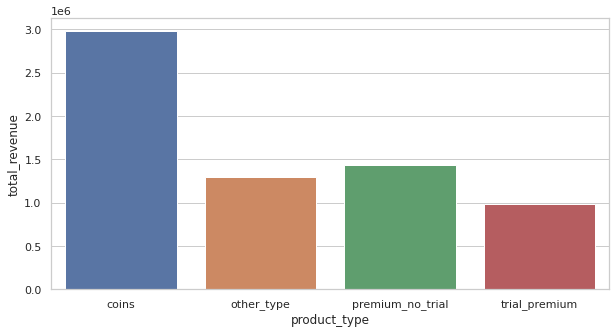

In [43]:
plt.figure(figsize=(10,5))
sns.barplot(data=product_type_vs_profit_b, x="product_type", y="total_revenue") 

In [44]:
group_b_full.product_type.value_counts()

coins               106
premium_no_trial     76
trial_premium        62
other_type           29
Name: product_type, dtype: int64

In [45]:
group_b_full.uid.nunique()

146

In [46]:
# Получаем срез пользователей с типом продукта 'premium_no_trial' 
group_b = group_b_full.query('product_type == "premium_no_trial"')
group_b.head()

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
9,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,1.0,1.0,95823,United States of America,2017-10-18 01:09:00,2017-10-18 01:15:00,6292,147,left_sidebar_menu,premium_no_trial
18,892426491,48,625,NaN,United States of America,"1,2,3",1,25,61,56,1.0,NaN,12597,United States of America,2017-10-14 10:13:00,2017-10-15 22:39:00,12597,147,autoreply_message,premium_no_trial
19,891558921,38,470,6.0,United States of America,"9,11",1,22,40,17,1.0,1.0,9997,United States of America,2017-01-11 03:07:00,2017-10-11 09:05:00,9100,147,left_sidebar_menu,premium_no_trial
31,891861048,35,319,6.0,Canada,"1,2,3,4,5,6,7,8,9,10,16",1,32,38,219,1.0,1.0,21359,Canada,2017-10-26 02:55:00,2017-10-11 19:00:00,3588,68,none,premium_no_trial
34,891861048,35,319,6.0,Canada,"1,2,3,4,5,6,7,8,9,10,16",1,32,38,219,1.0,1.0,21359,Canada,2017-10-26 02:55:00,2017-10-26 03:00:00,3588,68,none,premium_no_trial


In [47]:
group_b.shape

(76, 20)

In [48]:
group_b.uid.nunique()  # уникальных ID в группе В только 67 штук

67

In [49]:
group_b.uid.value_counts()

892065108    3
892339626    3
892097937    3
891861048    2
892261437    2
            ..
892186941    1
892050108    1
891508155    1
891882681    1
892205850    1
Name: uid, Length: 67, dtype: int64

In [50]:
group_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 9 to 269
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uid               76 non-null     int64         
 1   age               76 non-null     int64         
 2   attraction_coeff  76 non-null     int64         
 3   coins             30 non-null     float64       
 4   country_x         76 non-null     object        
 5   visit_days        73 non-null     object        
 6   gender            76 non-null     int64         
 7   age_filter_start  76 non-null     int64         
 8   age_filter_end    76 non-null     int64         
 9   views_count       76 non-null     int64         
 10  was_premium       76 non-null     float64       
 11  is_premium        69 non-null     float64       
 12  total_revenue     76 non-null     int64         
 13  country_y         76 non-null     object        
 14  joined_at         76 non-nu

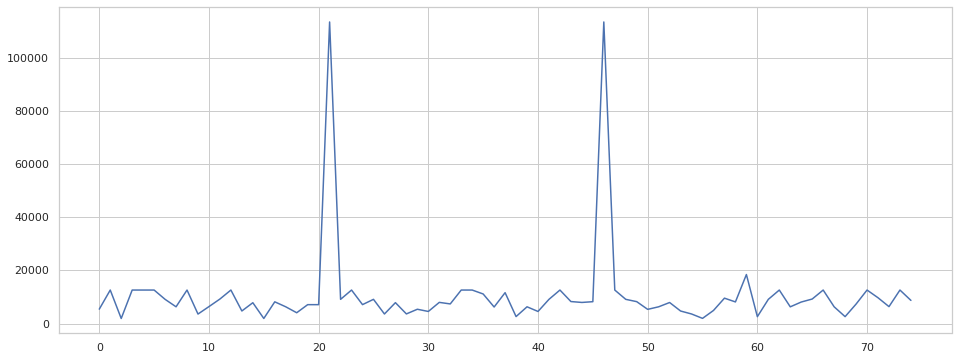

In [51]:
group_b.groupby(['paid_at'], as_index=False).agg({'revenue': 'sum'}).revenue.plot()

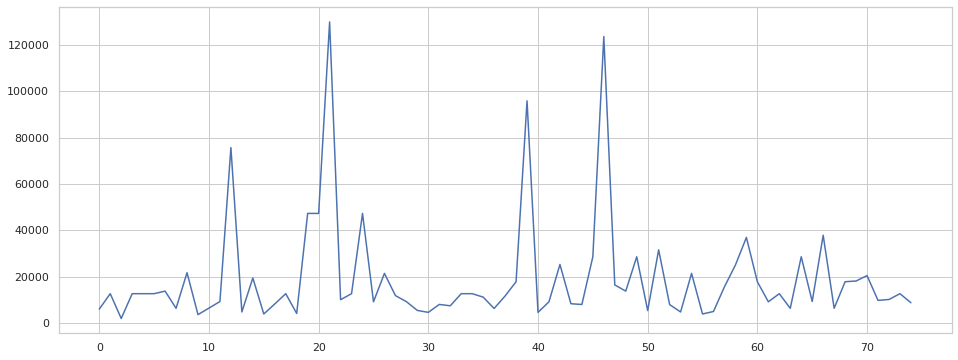

In [52]:
group_b.groupby(['paid_at'], as_index=False).agg({'total_revenue': 'sum'}).total_revenue.plot()

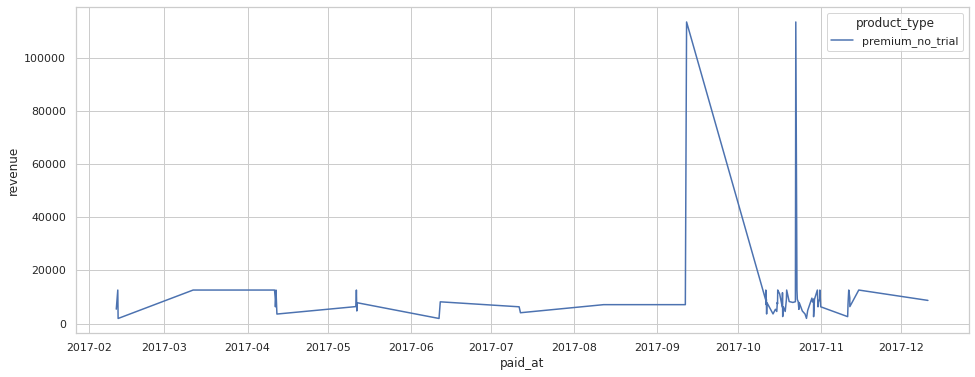

In [53]:
sns.lineplot(x='paid_at', y ='revenue', hue='product_type', data=group_b)

In [54]:
#                                         1.2. Контрольные группы

In [55]:
users_control_1.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


In [56]:
users_control_1.shape

(4340, 13)

In [57]:
users_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   int64  
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             60 non-null     float64
 4   country           4340 non-null   object 
 5   visit_days        3016 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       436 non-null    float64
 11  is_premium        192 non-null    float64
 12  total_revenue     4340 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 440.9+ KB


In [58]:
users_control_1.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.340000e+03,4340.000000,4340.000000,60.0000,4340.000000,4340.000000,4340.000000,4340.000000,436.0,192.0,4340.000000
mean,8.917578e+08,32.095392,312.048848,1745.9000,0.958065,26.793779,38.553226,44.467512,1.0,1.0,594.761982
std,1.125683e+06,10.257466,320.972130,12902.3577,0.200465,9.405103,15.226951,204.800272,0.0,0.0,7987.922925
min,8.910510e+08,16.000000,0.000000,1.0000,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913626e+08,24.000000,0.000000,8.0000,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,8.917272e+08,30.000000,238.500000,11.5000,1.000000,25.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,8.920898e+08,38.000000,518.000000,28.0000,1.000000,32.000000,45.000000,21.000000,1.0,1.0,0.000000
max,9.609370e+08,99.000000,1000.000000,99958.0000,1.000000,96.000000,102.000000,4953.000000,1.0,1.0,486330.000000


In [59]:
users_control_1.uid.nunique()      # все пользователи уникальны

4340

In [60]:
users_control_1.country.nunique()  # из какого количества стран

40

In [61]:
users_control_1.query('total_revenue == 0').shape[0]  # Из 4340 платежей 4148 равны 0.   

4148

In [62]:
#

In [63]:
transactions_control_1

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins
...,...,...,...,...,...,...,...,...
1002,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1003,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1004,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1005,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN


In [64]:
transactions_control_1.shape

(1007, 8)

In [65]:
transactions_control_1.info()  # полный набор, без проблем, кроме "пустышек"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           377 non-null    float64       
 1   country       377 non-null    object        
 2   joined_at     377 non-null    datetime64[ns]
 3   paid_at       377 non-null    datetime64[ns]
 4   revenue       377 non-null    float64       
 5   payment_id    377 non-null    float64       
 6   from_page     377 non-null    object        
 7   product_type  377 non-null    object        
dtypes: datetime64[ns](2), float64(3), object(3)
memory usage: 63.1+ KB


In [66]:
# Убираем строки с пропущенными значениями  
transactions_control_1 = transactions_control_1.dropna(subset=['product_type'])

In [67]:
transactions_control_1.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins


In [68]:
transactions_control_1.shape

(377, 8)

In [69]:
transactions_control_1.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377 entries, 0 to 376
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           377 non-null    float64       
 1   country       377 non-null    object        
 2   joined_at     377 non-null    datetime64[ns]
 3   paid_at       377 non-null    datetime64[ns]
 4   revenue       377 non-null    float64       
 5   payment_id    377 non-null    float64       
 6   from_page     377 non-null    object        
 7   product_type  377 non-null    object        
dtypes: datetime64[ns](2), float64(3), object(3)
memory usage: 26.5+ KB


In [70]:
transactions_control_1.uid.nunique()  # не все пользователи уникальны

193

In [71]:
transactions_control_1.uid.value_counts()

892333905.0    27
892069554.0    11
891707061.0    10
892366260.0    10
891367521.0    10
               ..
891645606.0     1
892148454.0     1
891622389.0     1
891699369.0     1
891292845.0     1
Name: uid, Length: 193, dtype: int64

In [72]:
transactions_control_1.describe(include='object')

,country,from_page,product_type
count,377,377,377
unique,18,25,4
top,United States of America,empty_likes,coins
freq,105,99,149


In [73]:
transactions_control_1.describe(include='datetime')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,joined_at,paid_at
count,377,377
unique,193,335
top,2017-10-16 01:38:00,2017-10-16 02:08:00
freq,27,5
first,2015-01-19 11:49:00,2016-12-14 16:16:00
last,2017-10-31 22:17:00,2017-12-11 21:57:00


In [74]:
transactions_control_1.groupby('product_type').agg({'revenue': 'sum'})

,revenue
product_type,
coins,871910.0
other_type,188422.0
premium_no_trial,779259.0
trial_premium,772720.0


In [75]:
 transactions_control_1.groupby('product_type', as_index=False).agg({'uid': 'count'})

,product_type,uid
0,coins,149
1,other_type,55
2,premium_no_trial,106
3,trial_premium,67


In [76]:
transactions_control_1.query('product_type == "premium_no_trial"').groupby('uid', as_index=False).agg({'revenue': 'count'})

,uid,revenue
0,891092322.0,1
1,891120969.0,1
2,891130164.0,1
3,891131061.0,1
4,891142386.0,1
...,...,...
94,892366260.0,2
95,892380033.0,1
96,892393119.0,2
97,892405224.0,1


In [77]:
transactions_control_1.query('product_type == "premium_no_trial"').groupby('uid', as_index=False).agg({'revenue': 'sum'})

,uid,revenue
0,891092322.0,5278.0
1,891120969.0,6292.0
2,891130164.0,4537.0
3,891131061.0,6292.0
4,891142386.0,4680.0
...,...,...
94,892366260.0,12584.0
95,892380033.0,4732.0
96,892393119.0,3614.0
97,892405224.0,6292.0


In [78]:
# Объединяем данные
group_a1_full = users_control_1.merge(transactions_control_1, how='right', on='uid')
group_a1_full.head()

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275,27,0,NaN,France,"1,2,3",1,24,30,2,1.0,1.0,13455,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,891319275,27,0,NaN,France,"1,2,3",1,24,30,2,1.0,1.0,13455,France,2017-05-11 19:57:00,2017-05-11 20:05:00,728.0,146.0,ad_to_photo,coins
2,892421826,31,43,NaN,Israel,"1,2,4,6,7,10,11,12,13,14,15,17,18,19,20,21,22,...",1,28,34,69,1.0,1.0,14586,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
3,891822480,28,337,10.0,Italy,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19",1,25,31,77,1.0,1.0,17810,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
4,891822480,28,337,10.0,Italy,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19",1,25,31,77,1.0,1.0,17810,Italy,2017-10-26 22:27:00,2017-01-11 16:50:00,1898.0,19.0,none,coins


In [79]:
group_a1_full.shape

(377, 20)

In [80]:
group_a1_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377 entries, 0 to 376
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uid               377 non-null    int64         
 1   age               377 non-null    int64         
 2   attraction_coeff  377 non-null    int64         
 3   coins             215 non-null    float64       
 4   country_x         377 non-null    object        
 5   visit_days        360 non-null    object        
 6   gender            377 non-null    int64         
 7   age_filter_start  377 non-null    int64         
 8   age_filter_end    377 non-null    int64         
 9   views_count       377 non-null    int64         
 10  was_premium       349 non-null    float64       
 11  is_premium        304 non-null    float64       
 12  total_revenue     377 non-null    int64         
 13  country_y         377 non-null    object        
 14  joined_at         377 non-

In [81]:
product_type_vs_profit_a1 = group_a1_full.groupby('product_type', as_index=False).total_revenue.sum()
product_type_vs_profit_a1

,product_type,total_revenue
0,coins,10126402
1,other_type,6067399
2,premium_no_trial,1700257
3,trial_premium,813995


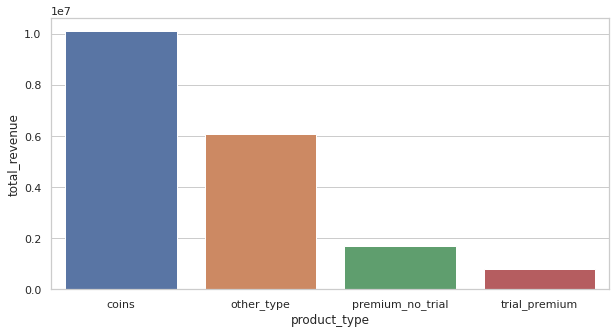

In [82]:
plt.figure(figsize=(10,5))
sns.barplot(data=product_type_vs_profit_a1, x="product_type", y="total_revenue")

In [83]:
group_a1_full.product_type.value_counts()

coins               149
premium_no_trial    106
trial_premium        67
other_type           55
Name: product_type, dtype: int64

In [84]:
# Получаем срез пользователей с типом продукта 'premium_no_trial' 
group_a1 = group_a1_full.query('product_type == "premium_no_trial"')
group_a1.head()

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
6,891822480,28,337,10.0,Italy,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19",1,25,31,77,1.0,1.0,17810,Italy,2017-10-26 22:27:00,2017-10-27 23:29:00,1898.0,68.0,none,premium_no_trial
7,891822480,28,337,10.0,Italy,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19",1,25,31,77,1.0,1.0,17810,Italy,2017-10-26 22:27:00,2017-07-11 00:04:00,6292.0,147.0,promo_09,premium_no_trial
23,892207959,21,230,NaN,France,"1,2,4,5,6,7,9,10,11,12,13,14,15,16,17,18,19,20...",1,18,24,430,1.0,1.0,18902,France,2017-10-18 18:30:00,2017-10-27 10:37:00,6292.0,147.0,promo_09,premium_no_trial
46,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,Italy,2017-10-16 01:38:00,2017-10-16 13:10:00,63037.0,147.0,no_sympathy,premium_no_trial
69,891739737,25,303,22.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18",1,22,28,89,1.0,1.0,21424,United States of America,2017-10-28 18:50:00,2017-11-11 06:05:00,6292.0,147.0,promo_09,premium_no_trial


In [85]:
group_a1.shape

(106, 20)

In [86]:
group_a1.uid.nunique()

99

In [87]:
group_a1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 6 to 373
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uid               106 non-null    int64         
 1   age               106 non-null    int64         
 2   attraction_coeff  106 non-null    int64         
 3   coins             39 non-null     float64       
 4   country_x         106 non-null    object        
 5   visit_days        102 non-null    object        
 6   gender            106 non-null    int64         
 7   age_filter_start  106 non-null    int64         
 8   age_filter_end    106 non-null    int64         
 9   views_count       106 non-null    int64         
 10  was_premium       106 non-null    float64       
 11  is_premium        93 non-null     float64       
 12  total_revenue     106 non-null    int64         
 13  country_y         106 non-null    object        
 14  joined_at         106 non-

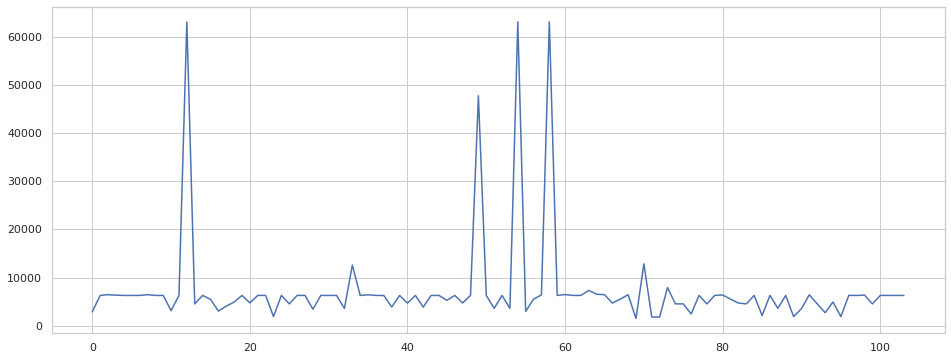

In [88]:
group_a1.groupby(['paid_at'], as_index=False).agg({'revenue': 'sum'}).revenue.plot()

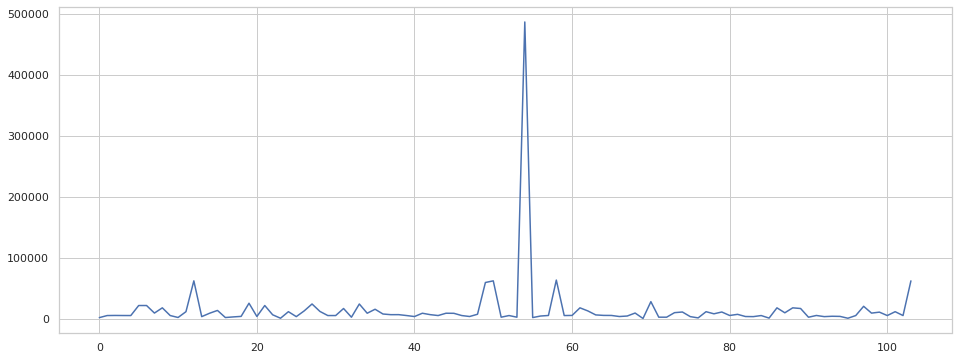

In [89]:
group_a1.groupby(['paid_at'], as_index=False).agg({'total_revenue': 'sum'}).total_revenue.plot()

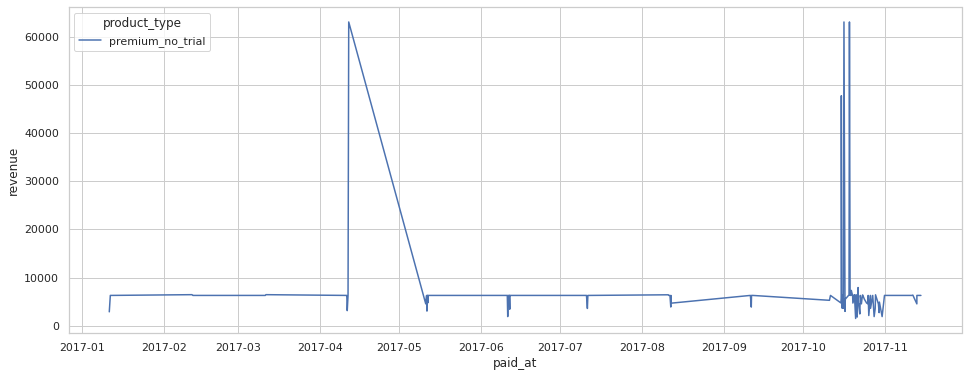

In [90]:
sns.lineplot(x='paid_at', y='revenue', hue='product_type', data=group_a1)

In [91]:
#

In [92]:
users_control_2.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0


In [93]:
users_control_2.shape

(4264, 13)

In [94]:
users_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   int64  
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             61 non-null     float64
 4   country           4264 non-null   object 
 5   visit_days        2900 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       411 non-null    float64
 11  is_premium        191 non-null    float64
 12  total_revenue     4264 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 433.2+ KB


In [95]:
users_control_2.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.264000e+03,4264.000000,4264.000000,61.000000,4264.000000,4264.000000,4264.000000,4264.000000,411.0,191.0,4264.000000
mean,8.917694e+08,32.046201,317.957317,18.147541,0.954268,26.954268,38.906895,45.064493,1.0,1.0,450.384146
std,2.520759e+06,10.170721,326.191737,35.439543,0.208927,9.546657,15.955574,318.188992,0.0,0.0,2859.242228
min,8.910509e+08,16.000000,0.000000,1.000000,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913453e+08,25.000000,0.000000,4.000000,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,8.917205e+08,30.000000,250.000000,10.000000,1.000000,25.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,8.920735e+08,38.000000,548.500000,20.000000,1.000000,32.000000,45.000000,20.000000,1.0,1.0,0.000000
max,1.053059e+09,99.000000,1000.000000,271.000000,1.000000,94.000000,99.000000,16157.000000,1.0,1.0,81796.000000


In [96]:
users_control_2.uid.nunique()  # все пользователи уникальны

4264

In [97]:
users_control_2.country.nunique()  # из какого количества стран

45

In [98]:
users_control_2.query('total_revenue == 0').shape[0]  # из 4264 платежей 4077 равны 0.    

4077

In [99]:
#

In [100]:
transactions_control_2.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial


In [101]:
transactions_control_2.shape

(328, 8)

In [102]:
transactions_control_2.info()  # полный df, без проблем 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           328 non-null    int64         
 1   country       328 non-null    object        
 2   joined_at     328 non-null    datetime64[ns]
 3   paid_at       328 non-null    datetime64[ns]
 4   revenue       328 non-null    int64         
 5   payment_id    328 non-null    int64         
 6   from_page     328 non-null    object        
 7   product_type  328 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 20.6+ KB


In [103]:
transactions_control_2.uid.nunique()  # не все пользователи уникальны

187

In [104]:
transactions_control_2.uid.value_counts()

891637005    11
892230228    10
891080040     8
892139829     6
892435536     5
             ..
891924273     1
891592491     1
892149546     1
891213609     1
891075072     1
Name: uid, Length: 187, dtype: int64

In [105]:
transactions_control_2.describe(include='object')

,country,from_page,product_type
count,328,328,328
unique,19,18,4
top,United States of America,empty_likes,coins
freq,107,101,124


In [106]:
transactions_control_2.describe(include='datetime')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,joined_at,paid_at
count,328,328
unique,187,309
top,2017-10-30 15:22:00,2017-10-23 20:17:00
freq,11,3
first,2017-01-11 08:36:00,2017-01-11 05:34:00
last,2017-10-31 17:43:00,2017-12-11 23:28:00


In [107]:
 transactions_control_2.groupby('product_type').agg({'revenue': 'sum'})

,revenue
product_type,
coins,402909
other_type,128739
premium_no_trial,744809
trial_premium,643981


In [108]:
 transactions_control_2.groupby('product_type').agg({'uid': 'count'})

,uid
product_type,
coins,124
other_type,44
premium_no_trial,107
trial_premium,53


In [109]:
transactions_control_2.query('product_type == "premium_no_trial"').groupby('uid', as_index=False).agg({'revenue': 'count'})

,uid,revenue
0,891068079,1
1,891077727,1
2,891112263,1
3,891136632,1
4,891143379,1
...,...,...
97,892343331,1
98,892354854,1
99,892364742,1
100,892385232,1


In [110]:
transactions_control_2.query('product_type == "premium_no_trial"').groupby('uid', as_index=False).agg({'revenue': 'sum'})

,uid,revenue
0,891068079,6292
1,891077727,6292
2,891112263,4680
3,891136632,10413
4,891143379,6500
...,...,...
97,892343331,2873
98,892354854,6435
99,892364742,4797
100,892385232,6292


In [111]:
# Объединяем данные 
group_a2_full = users_control_2.merge(transactions_control_2, how='right', on='uid')
group_a2_full

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,28,229,6.0,Argentina,"1,2,3,4,5,6,7,8,9",1,18,45,48,1.0,1.0,18902,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,891266616,28,229,6.0,Argentina,"1,2,3,4,5,6,7,8,9",1,18,45,48,1.0,1.0,18902,Argentina,2017-06-11 15:25:00,2017-08-11 05:22:00,6305,19,empty_likes,coins
2,891266616,28,229,6.0,Argentina,"1,2,3,4,5,6,7,8,9",1,18,45,48,1.0,1.0,18902,Argentina,2017-06-11 15:25:00,2017-07-11 00:08:00,6292,147,promo_09,premium_no_trial
3,892186737,30,250,NaN,Chile,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",1,27,33,8,1.0,1.0,4732,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
4,891959004,45,0,NaN,United States of America,"1,2,3,4,6,7,8,9,10,11,12,13,15,16,17,18,19,20,...",1,42,48,0,1.0,1.0,10153,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,891985866,34,349,4.0,Belgium,"1,2,3,4,5,6,7,8,10,11,12,14,16,17,19,21,22",1,21,99,63,1.0,1.0,20605,Belgium,2017-10-23 13:19:00,2017-10-30 15:35:00,16640,147,trial_vip_popup,trial_premium
324,891673269,28,703,NaN,United Arab Emirates,1,1,25,31,27,1.0,1.0,13247,United Arab Emirates,2017-10-29 21:40:00,2017-05-11 23:49:00,13247,147,dating,trial_premium
325,892032072,26,0,NaN,United Kingdom (Great Britain),"1,2,3",0,16,99,16157,1.0,NaN,3588,United Kingdom (Great Britain),2017-10-22 14:21:00,2017-10-23 15:37:00,3588,68,none,premium_no_trial
326,891491145,20,875,NaN,United States of America,"1,2,3",1,18,31,24,1.0,1.0,12727,United States of America,2017-02-11 18:13:00,2017-09-11 20:32:00,12727,147,send_message,trial_premium


In [112]:
group_a2_full.shape

(328, 20)

In [113]:
group_a2_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328 entries, 0 to 327
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uid               328 non-null    int64         
 1   age               328 non-null    int64         
 2   attraction_coeff  328 non-null    int64         
 3   coins             164 non-null    float64       
 4   country_x         328 non-null    object        
 5   visit_days        309 non-null    object        
 6   gender            328 non-null    int64         
 7   age_filter_start  328 non-null    int64         
 8   age_filter_end    328 non-null    int64         
 9   views_count       328 non-null    int64         
 10  was_premium       312 non-null    float64       
 11  is_premium        269 non-null    float64       
 12  total_revenue     328 non-null    int64         
 13  country_y         328 non-null    object        
 14  joined_at         328 non-

In [114]:
product_type_vs_profit_a2 = group_a2_full.groupby('product_type', as_index=False).total_revenue.sum()
product_type_vs_profit_a2

,product_type,total_revenue
0,coins,1802034
1,other_type,609830
2,premium_no_trial,1128205
3,trial_premium,726193


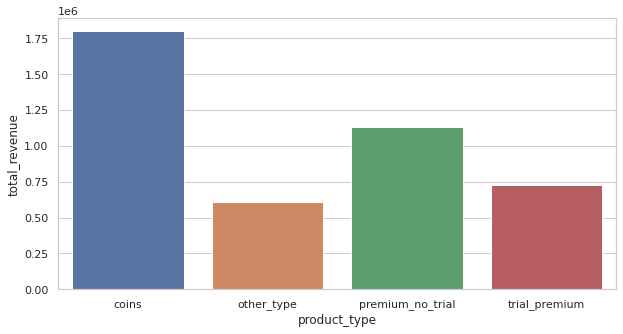

In [115]:
plt.figure(figsize=(10,5))
sns.barplot(data=product_type_vs_profit_a2, x="product_type", y="total_revenue") 

In [116]:
group_a2_full.product_type.value_counts()

coins               124
premium_no_trial    107
trial_premium        53
other_type           44
Name: product_type, dtype: int64

In [117]:
group_a2_full.uid.nunique()

187

In [118]:
# Получаем срез пользователей с типом продукта 'premium_no_trial' 
group_a2 = group_a2_full.query('product_type == "premium_no_trial"')
group_a2.head()

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
2,891266616,28,229,6.0,Argentina,"1,2,3,4,5,6,7,8,9",1,18,45,48,1.0,1.0,18902,Argentina,2017-06-11 15:25:00,2017-07-11 00:08:00,6292,147,promo_09,premium_no_trial
3,892186737,30,250,NaN,Chile,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",1,27,33,8,1.0,1.0,4732,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
6,892115478,40,99,NaN,Spain,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",1,37,43,994,1.0,1.0,11154,Spain,2017-10-20 20:39:00,2017-10-20 20:43:00,6474,147,left_sidebar_menu,premium_no_trial
8,891592941,38,112,4.0,Switzerland,"1,2,3,4,5,6,7,8,9,10,11,12,13",1,35,41,62,1.0,1.0,10192,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial
10,892245918,34,622,NaN,France,"1,2,3,4,5,6,7,8,11,12,13,14,15,16,17,18,19,20,...",1,20,39,61,1.0,1.0,6292,France,2017-10-17 21:05:00,2017-10-17 22:35:00,6292,147,autoreply_message,premium_no_trial


In [119]:
group_a2.shape

(107, 20)

In [120]:
group_a2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107 entries, 2 to 327
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uid               107 non-null    int64         
 1   age               107 non-null    int64         
 2   attraction_coeff  107 non-null    int64         
 3   coins             33 non-null     float64       
 4   country_x         107 non-null    object        
 5   visit_days        98 non-null     object        
 6   gender            107 non-null    int64         
 7   age_filter_start  107 non-null    int64         
 8   age_filter_end    107 non-null    int64         
 9   views_count       107 non-null    int64         
 10  was_premium       107 non-null    float64       
 11  is_premium        97 non-null     float64       
 12  total_revenue     107 non-null    int64         
 13  country_y         107 non-null    object        
 14  joined_at         107 non-

In [121]:
group_a2.uid.nunique()

102

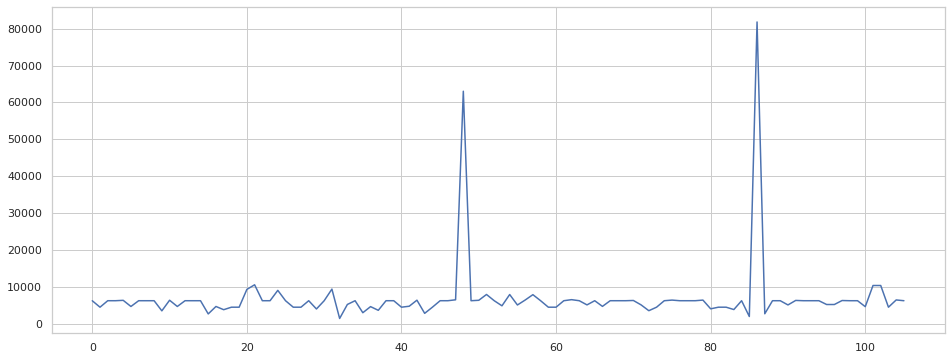

In [122]:
group_a2.groupby(['paid_at'], as_index=False).agg({'revenue': 'sum'}).revenue.plot()

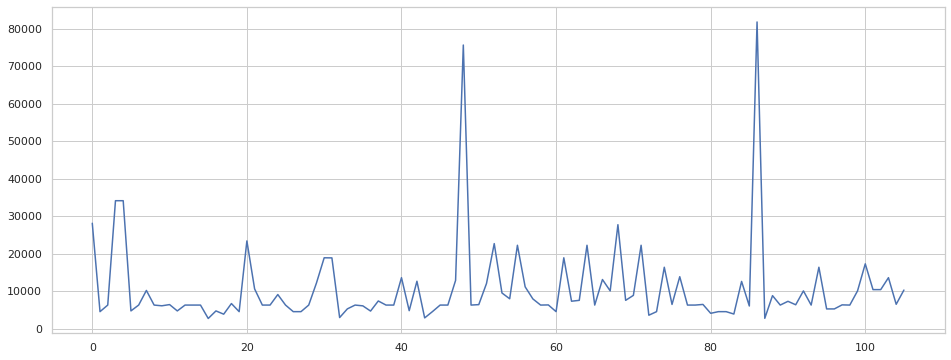

In [123]:
group_a2.groupby(['paid_at'], as_index=False).agg({'total_revenue': 'sum'}).total_revenue.plot()

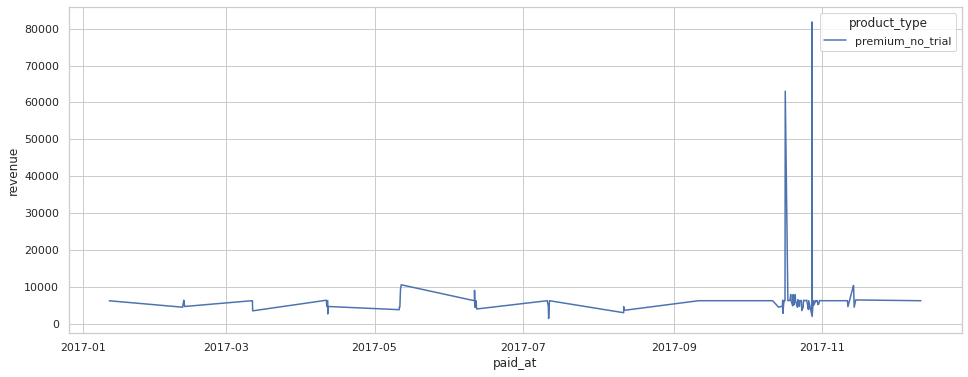

In [124]:
sns.lineplot(x='paid_at', y='revenue', hue='product_type', data=group_a2)

In [125]:
#                                  1.3. Некоторые уточнения согласно условиям эксперимента.

In [126]:
#   Подразумевается, что эксперимент проводился в один и тот же временной период для всех групп. 
#   Т.е. время начала и конца эксперимента в группах А1,А2,В должно быть синхронизированно. 
#   Что это за интервал времени?
#                      c '2017-02-11 00:13:00' по '2017-11-14 16:50:00'

In [127]:
group_b.paid_at.min()

Timestamp('2017-02-11 00:13:00')

In [128]:
group_b.paid_at.max()

Timestamp('2017-12-11 00:11:00')

In [129]:
group_a1.paid_at.min()

Timestamp('2017-01-11 05:16:00')

In [130]:
group_a1.paid_at.max()

Timestamp('2017-11-14 16:50:00')

In [131]:
group_a2.paid_at.min()

Timestamp('2017-01-11 22:36:00')

In [132]:
group_a2.paid_at.max()

Timestamp('2017-12-11 15:23:00')

In [133]:
lower_edge_time = max(group_b.paid_at.min(), group_a1.paid_at.min(), group_a2.paid_at.min())

In [134]:
lower_edge_time

Timestamp('2017-02-11 00:13:00')

In [135]:
upper_edge_time = min(group_b.paid_at.max(), group_a1.paid_at.max(), group_a2.paid_at.max())

In [136]:
upper_edge_time

Timestamp('2017-11-14 16:50:00')

In [137]:
# Приводим группы к временным границам эксперимента
group_b = group_b.query('(paid_at >= "2017-02-11 00:13:00") & (paid_at <= "2017-11-14 16:50:00")')
group_a1 = group_a1.query('(paid_at >= "2017-02-11 00:13:00") & (paid_at <= "2017-11-14 16:50:00")')
group_a2 = group_a2.query('(paid_at >= "2017-02-11 00:13:00") & (paid_at <= "2017-11-14 16:50:00")')

In [138]:

#     Видим, что количество стран в контрольных группах А1,А2 одинаково; набор стран в группах А1,А2 несколько разнится;
#  пользователи между группами А1,А2 распределены не совсем равномерно и корректно - а ведь это должно являться важным
#  начальным условием для А/А теста.
#     Большой вопрос вызывает набор стран в тестовой группе В (на 1 страну меньше; выбраны несколько других стран; количество
#  пользователей из каждой страны не совпадает с аналогичным набором из контрольных групп А1,А2).
#     Кроме того, начальные, "сырые" данные говорят о 273 пользователях из группы "В", 377 из группы "А1", 328 из группы "А2".  
#     Создается общее впечатление, что эксперимент организован "нечисто", сплитование не совсем корректно,
#  вероятность ошибки возрастает. 


In [139]:
group_b.country_x.nunique()

16

In [140]:
group_b.country_x.value_counts()

United States of America          20
Italy                              8
France                             6
United Arab Emirates               6
Spain                              6
Chile                              6
United Kingdom (Great Britain)     5
Canada                             4
Argentina                          4
Israel                             2
Germany                            2
Belgium                            1
Mexico                             1
Australia                          1
Latvia                             1
Turkey                             1
Name: country_x, dtype: int64

In [141]:
group_a1.country_x.nunique()

17

In [142]:
group_a1.country_x.value_counts()

United States of America          28
Italy                             15
France                            12
Israel                            10
United Kingdom (Great Britain)     5
Argentina                          5
Spain                              5
Chile                              4
Canada                             4
Germany                            4
United Arab Emirates               3
Turkey                             3
India                              2
Australia                          1
Switzerland                        1
Belgium                            1
Portugal                           1
Name: country_x, dtype: int64

In [143]:
group_a2.country_x.nunique()

17

In [144]:
group_a2.country_x.value_counts()

United States of America          33
Spain                             11
United Kingdom (Great Britain)    11
France                             8
Argentina                          6
Chile                              6
Belgium                            5
Portugal                           5
United Arab Emirates               4
Italy                              3
Switzerland                        3
Israel                             2
Germany                            2
Australia                          2
Austria                            1
Ukraine                            1
Canada                             1
Name: country_x, dtype: int64

In [145]:
# количество участников (со всеми типами подписки)

In [146]:
full_0 = (users_test.uid + transactions_test.uid).dropna().drop_duplicates()           # группа "В" перед началом эксперимента
full_0.shape[0]

273

In [147]:
full_1 = (users_control_1.uid + transactions_control_1.uid).dropna().drop_duplicates() # группа "А1" перед началом эксперимента
full_1.shape[0]

377

In [148]:
full_2 = (users_control_2.uid + transactions_control_2.uid).dropna().drop_duplicates()  #группа "А2" перед началом эксперимента
full_2.shape[0]

328

In [149]:
#                                          2. ПРОВЕРКА УСПЕШНОСТИ ЭКСПЕРИМЕНТА 

In [150]:
data_column_a1 = group_a1['revenue'].to_frame()
data_column_a2 = group_a2['revenue'].to_frame()
data_column_b = group_b['revenue'].to_frame() 

In [151]:

#   Проверим группы на нормальность распределения метрики 'revenue' внутри группы, используя тест Шапиро-Уилка.
#   Нулевая гипотеза H(0) в случае Шапиро-Уилка - нормальность распределения метрики.

#   Видим, что во всех случаях p<0.05, поэтому отклоняем H(0), распределение отличается от нормального - в условиях небольших
#   выборок это исключает возможность применения T-критерия Стьюдента.


In [152]:
stats.shapiro(data_column_a1)

(0.29694753885269165, 4.451721266872738e-20)

In [153]:
stats.shapiro(data_column_a2)

(0.23587727546691895, 7.95343448595756e-21)

In [154]:
stats.shapiro(data_column_b)

(0.2974923253059387, 4.5554252466503925e-17)

In [155]:
#

In [156]:

#   Проверяем, сходится ли А1\A2 тест; используем непараметрический тест – U-критерий Манна-Уитни.
#   Видим, что p>0.05, не можем отклонить гипотезу H(0) в паре A1/A2 - различий по метрике 'revenue' между группами нет.  


In [157]:
mannwhitneyu(data_column_a1, data_column_a2)  

MannwhitneyuResult(statistic=5186.5, pvalue=0.29971498901894394)

In [158]:
#   Было бы интересно проверить сходимость А1\A2 теста по другому:

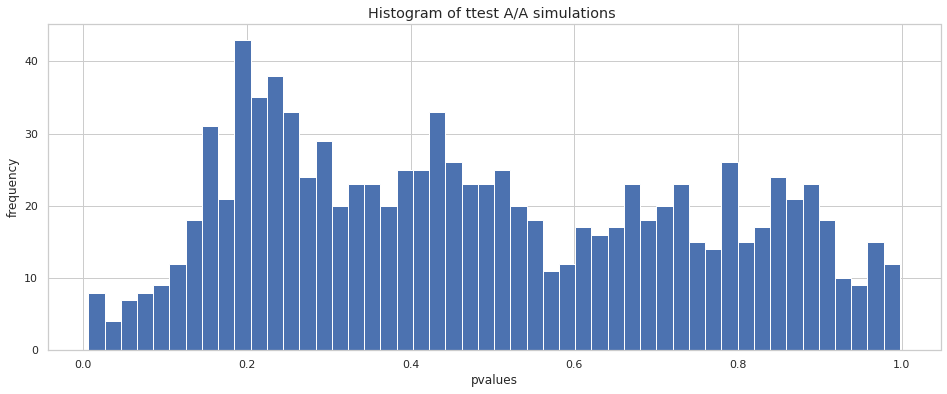

0.014

In [159]:
n = 104
simulations = 1000
n_s = 30
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = group_a1['revenue'].sample(n_s, replace = False).values
    s2 = group_a2['revenue'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

In [160]:
#   Видим, что FPR < альфа=0.05
#   A/A тест по метрике 'revenue' сходится, все нормально.

In [161]:
#

In [162]:
# Переходим к анализу A1+A2/B теста

In [163]:
data_column_a1.describe()

,revenue
count,104.000000
mean,7404.625000
std,10591.716251
min,1508.000000
25%,4537.000000
50%,6292.000000
75%,6292.000000
max,63037.000000


In [164]:
data_column_a2.describe()

,revenue
count,104.000000
mean,6978.250000
std,9427.657801
min,1482.000000
25%,4644.250000
50%,6292.000000
75%,6292.000000
max,81796.000000


In [165]:
data_column_b.describe()

,revenue
count,74.000000
mean,10667.729730
std,17540.225304
min,1898.000000
25%,5609.500000
50%,7943.000000
75%,9659.000000
max,113477.000000


In [166]:
data_column_a1_a2 = pd.concat([group_a1['revenue'], group_a2['revenue']], ignore_index=True).to_frame()
data_column_a1_a2 = data_column_a1_a2.astype('int64')
data_column_a1_a2

,revenue
0,1898
1,6292
2,6292
3,63037
4,6292
...,...
203,6292
204,7930
205,6292
206,3588


In [167]:
data_column_a1_a2.max()

revenue    81796
dtype: int64

In [168]:
data_column_a1_a2.min()

revenue    1482
dtype: int64

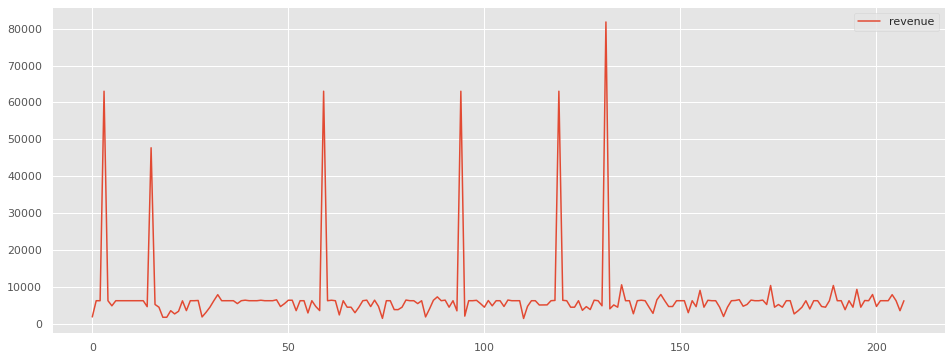

In [169]:
data_column_a1_a2.plot()

In [170]:
data_column_b.max()

revenue    113477
dtype: int64

In [171]:
data_column_b.min()

revenue    1898
dtype: int64

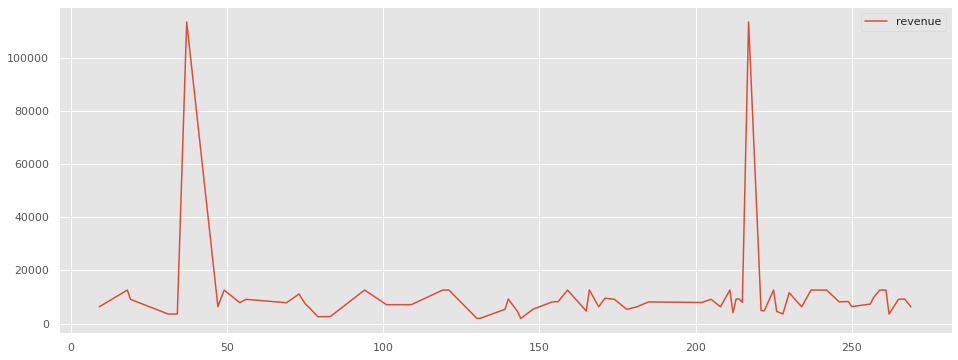

In [172]:
data_column_b.plot()

In [173]:

#    Применяем непараметрику Манна-Уитни.
#    Получаем p<0.05, что позволяет нам отвергнуть гипотезу H(0),
#    различия между тестовой группой В и контрольной A1+A2 по метрике 'revenue' достоверны. 


In [174]:
mannwhitneyu(data_column_a1_a2, data_column_b) 

MannwhitneyuResult(statistic=4432.5, pvalue=1.9387186418004354e-08)

In [175]:
# Было бы интересно проверить то же самое с помощью bootstrap:

In [176]:
def get_bootstrap(
    data_column_1,
    data_column_2, 
    boot_it = 1000, 
    statistic = np.mean,
    bootstrap_conf_level = 0.95 
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): 
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [177]:
sample_1 = data_column_b
sample_2 = data_column_a1_a2

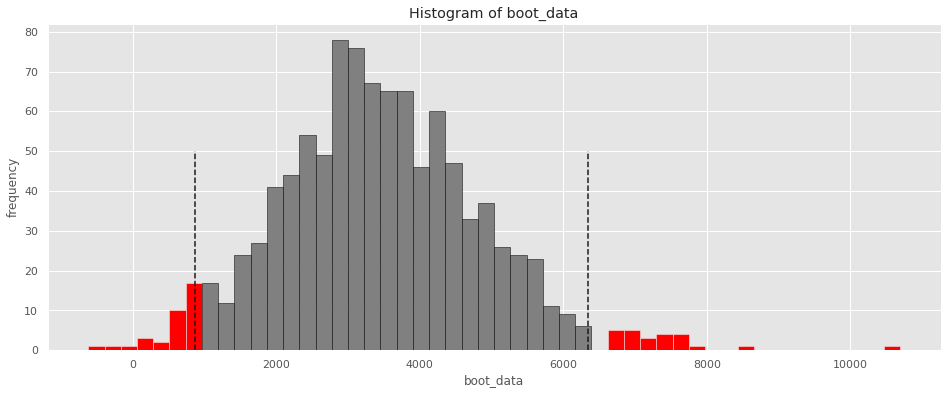

In [178]:
booted_data = get_bootstrap(sample_1, sample_2) 

In [179]:
booted_data["quants"]  # ДИ

,0
0.025,871.032813
0.975,6338.101562


In [180]:
booted_data["p_value"]  # альфа

0.01341610190108546

In [181]:

# Видим, что в случае применения bootstrap с параметром распределения mean, значение "0" не попадает в ДИ, P<0.05, 
# как следствие, можем отвергнуть гипотезу H(0) о том, что нет различий между контрольной и тестовой группой
# по метрике 'revenue'. Можем принять гипотезу H(1) - различия между группами по метрике 'revenue' - достоверны.


In [182]:

#  ВЫВОД:
#      Таким образом, можем констатировать, что эксперимент в целом был успешен. Есть вопросы к планированию эксперимента
#  (некорректное сплитование на группы), что может поставить под вопрос ценность полученных данных.

#      Проанализировав некоторыё основные метрики (Revenue, ARPPU, Active Users) можно увидеть, что за период эксперимента
#  в тестовой группе "В" размер Revenue стал несколько меньше, чем в группе "А1", но больше чем в "А2";  
#  количество Active Users в тестовой группе "В" упало по сравнению с "А1" и "А2" (можно предположить, что они ушли с
#  премиум-подписки в связи с изменившимися тарифами); в то же время за счет изменения стоимости премиум-подписки и
#  сокращения числа пользователей, в тестовой группе "В", по сравнению с группами "А1" и "А2", ощутимо выросла метрика ARPPU.


In [183]:
# Revenue по сегменту "premium_no_trial"

In [184]:
Revenue_b = group_b.total_revenue.sum()      
Revenue_b

1412307

In [185]:
Revenue_a1 = group_a1.total_revenue.sum()    
Revenue_a1

1691079

In [186]:
Revenue_a2 = group_a2.total_revenue.sum()    
Revenue_a2

1083290

In [187]:
# Revenue (все типы подписки) 

In [188]:
Revenue_b = group_b_full.total_revenue.sum()  
Revenue_b

6700811

In [189]:
Revenue_a1 = group_a1_full.total_revenue.sum()    
Revenue_a1

18708053

In [190]:
Revenue_a2 = group_a2_full.total_revenue.sum()   
Revenue_a2

4266262

In [191]:
# ARPPU

In [192]:
ARPPU_b = group_b.total_revenue.sum() / group_b.uid.count()     # ARPPU тестовой группы "В" по сегменту "premium_no_trial"
ARPPU_b

19085.22972972973

In [193]:
ARPPU_a1 = group_a1.total_revenue.sum() / group_a1.uid.count()  # ARPPU тестовой группы "A1" по сегменту "premium_no_trial"
ARPPU_a1

16260.375

In [194]:
ARPPU_a2 = group_a2.total_revenue.sum() / group_a2.uid.count()   # ARPPU тестовой группы "A2" по сегменту "premium_no_trial"
ARPPU_a2

10416.25

In [195]:
# Active Users (сегмент "premium_no_trial")

In [196]:
group_b.uid.nunique()

65

In [197]:
group_a1.uid.nunique()

97

In [198]:
group_a2.uid.nunique()

99

In [199]:
# Active Users (все типы подписки)

In [200]:
group_b_full.uid.nunique()

146

In [201]:
group_a1_full.uid.nunique()

193

In [202]:
group_a2_full.uid.nunique()

187

In [203]:
#                       3. ИМЕЕТ ЛИ НОВОВВЕДЕНИЕ СМЫСЛ СРЕДИ КАКИХ-ЛИБО КОНКРЕТНЫХ ГРУПП ПОЛЬЗОВАТЕЛЕЙ

In [204]:
#                                            3.1. Пилотажный анализ проблемы

In [205]:

#      Что значит "нововведение имеет смысл среди каких-либо конкретных групп пользователей"? Речь идет об изменении
#   стоимости премиум-подписки для каких-то конкретных групп пользователей. Т.е. надо выявить силу и характер взаимосвязи между
#   какими-то переменными, одна из которых - нормированная выручка (ЗП), при условии что product_type = "premium" 
#   (в варианте no_trial).

#      Интересно, кто они, пользователи, оплачивающие тариф "premium_no_trial"? За что готовы платить, каковы их предпочтения
#   или может быть какие-то отличительные признаки? Есть смысл посмотреть на это сначало на одной из контрольных, "чистых"
#   групп, ещё не подвергшейся экспериментальному воздействию.    
    
#      Логичным является предположить, что группы пользователей, среди которых есть смысл делать нововведение,
#   могут быть обнаружены в процессе работы, например, со следующими категориями предоставленных данных:
#       -age (возраст) - вероятно пользователи возраста 20-30 лет, более мотивированы на знакомства, чем в 50-60 лет;
#       -coins (внутренняя валюта) - раз люди вложились во внутреннюю валюту, они наверное заинтересованы в присутствии на сайте;
#       -views_count (число полученных оценок) - чаще всего лидеры, активные пользователи сайта, в "топе"; 
#       -country (страна) - страны различаются по уровню жизни, экономического развитию, традициям, 
#                                                                                                     и т.д.


In [206]:
group_a2.head()

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
2,891266616,28,229,6.0,Argentina,"1,2,3,4,5,6,7,8,9",1,18,45,48,1.0,1.0,18902,Argentina,2017-06-11 15:25:00,2017-07-11 00:08:00,6292,147,promo_09,premium_no_trial
3,892186737,30,250,NaN,Chile,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",1,27,33,8,1.0,1.0,4732,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
6,892115478,40,99,NaN,Spain,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",1,37,43,994,1.0,1.0,11154,Spain,2017-10-20 20:39:00,2017-10-20 20:43:00,6474,147,left_sidebar_menu,premium_no_trial
8,891592941,38,112,4.0,Switzerland,"1,2,3,4,5,6,7,8,9,10,11,12,13",1,35,41,62,1.0,1.0,10192,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial
10,892245918,34,622,NaN,France,"1,2,3,4,5,6,7,8,11,12,13,14,15,16,17,18,19,20,...",1,20,39,61,1.0,1.0,6292,France,2017-10-17 21:05:00,2017-10-17 22:35:00,6292,147,autoreply_message,premium_no_trial


In [207]:
(group_a2.country_x ==  group_a2.country_y).unique()

array([ True])

In [208]:
group_a2 = group_a2.drop(['country_y'], axis=1)  # убираем дубликат колонки "country_x"

In [209]:
group_a2['frequency'] = (group_a2['visit_days'].str.count(',') + 1)  # создаем новую колонку "frequency" на основе "visit_days"

In [210]:
group_a2 = group_a2.fillna({'coins': group_a2.coins.median()})  # убираем NaN в 'coins'

In [211]:
group_a2.shape

(104, 20)

In [212]:
group_a2.isnull().sum()

uid                  0
age                  0
attraction_coeff     0
coins                0
country_x            0
visit_days           9
gender               0
age_filter_start     0
age_filter_end       0
views_count          0
was_premium          0
is_premium          10
total_revenue        0
joined_at            0
paid_at              0
revenue              0
payment_id           0
from_page            0
product_type         0
frequency            9
dtype: int64

In [213]:
group_a2 = group_a2.fillna({'frequency': group_a2.frequency.median()})  # убираем NaN в 'frequency'

In [214]:

#    Прибегнем к визуализации, например диаграммы рассеяния неплохо подходят для исследования зависимости между переменными;
# возможно это поможет нам определиться, какие факторы можно (нужно) взять для дальнейшей работы.


Text(0, 0.5, 'Нормированная выручка')

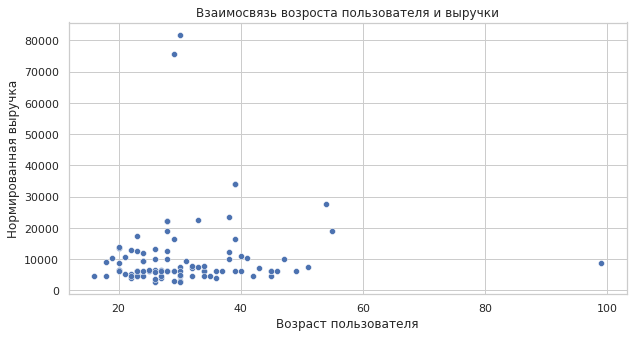

In [215]:
sns.set(style='whitegrid', rc={'figure.figsize': (10,5)})
sns.scatterplot(x = 'age', y = 'total_revenue', data = group_a2)
plt.title('Взаимосвязь возроста пользователя и выручки')
plt.xlabel('Возраст пользователя')
plt.ylabel('Нормированная выручка')

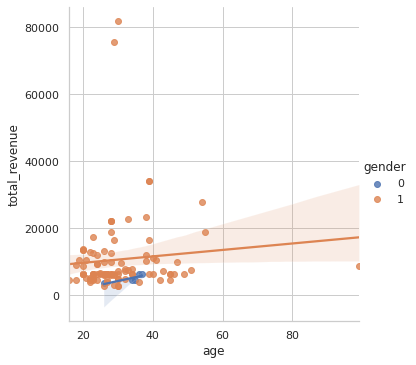

In [216]:
sns.set(style='whitegrid', rc={'figure.figsize': (10,5)})
sns.lmplot(x='age', y='total_revenue', hue='gender', data=group_a2)  # с добавлением группирующей переменной 'gender'

In [217]:
group_b_full.age.describe()

count    273.000000
mean      34.018315
std       14.677778
min       17.000000
25%       25.000000
50%       32.000000
75%       37.000000
max       99.000000
Name: age, dtype: float64

In [218]:
group_a1_full.age.describe()

count    377.000000
mean      30.315650
std        9.706523
min       16.000000
25%       24.000000
50%       27.000000
75%       35.000000
max       99.000000
Name: age, dtype: float64

In [219]:
group_a2_full.age.describe()

count    328.000000
mean      32.765244
std       11.600238
min       16.000000
25%       25.000000
50%       30.000000
75%       39.000000
max       99.000000
Name: age, dtype: float64

In [220]:
# Предварительное заключение: 'age' - интересный фактор влияния, особенно если разбить на возрастные подгруппы 

In [221]:
#

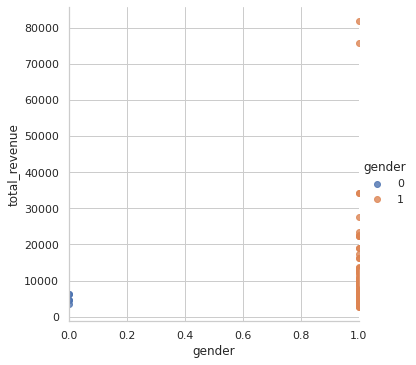

In [222]:
sns.set(style='whitegrid', rc={'figure.figsize': (10,5)})
sns.lmplot(x='gender', y='total_revenue', hue='gender', data=group_a2)

In [223]:
group_a2_full.gender.value_counts() 

1    321
0      7
Name: gender, dtype: int64

In [224]:
group_a1_full.gender.value_counts() 

1    373
0      4
Name: gender, dtype: int64

In [225]:
group_b_full.gender.value_counts() 

1    271
0      2
Name: gender, dtype: int64

In [226]:
# Предварительное заключение: представителей "gender=0" (скорее всего это женщины) очень мало, основная масса пользователей
# имеют "gender=1". Фактор "gender" не очень интересен для дальнейшего анализа.

In [227]:
#

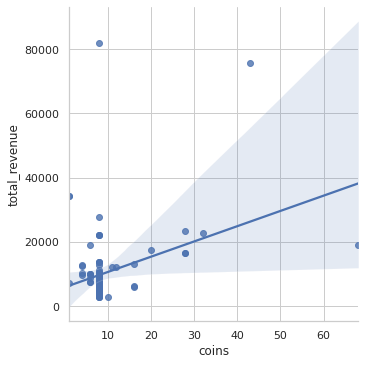

In [228]:
sns.lmplot(x='coins', y='total_revenue', data=group_a2)

In [229]:
group_b_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273 entries, 0 to 272
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uid               273 non-null    int64         
 1   age               273 non-null    int64         
 2   attraction_coeff  273 non-null    int64         
 3   coins             150 non-null    float64       
 4   country_x         273 non-null    object        
 5   visit_days        253 non-null    object        
 6   gender            273 non-null    int64         
 7   age_filter_start  273 non-null    int64         
 8   age_filter_end    273 non-null    int64         
 9   views_count       273 non-null    int64         
 10  was_premium       265 non-null    float64       
 11  is_premium        240 non-null    float64       
 12  total_revenue     273 non-null    int64         
 13  country_y         273 non-null    object        
 14  joined_at         273 non-

In [230]:
group_a1_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377 entries, 0 to 376
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uid               377 non-null    int64         
 1   age               377 non-null    int64         
 2   attraction_coeff  377 non-null    int64         
 3   coins             215 non-null    float64       
 4   country_x         377 non-null    object        
 5   visit_days        360 non-null    object        
 6   gender            377 non-null    int64         
 7   age_filter_start  377 non-null    int64         
 8   age_filter_end    377 non-null    int64         
 9   views_count       377 non-null    int64         
 10  was_premium       349 non-null    float64       
 11  is_premium        304 non-null    float64       
 12  total_revenue     377 non-null    int64         
 13  country_y         377 non-null    object        
 14  joined_at         377 non-

In [231]:
group_a2_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328 entries, 0 to 327
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uid               328 non-null    int64         
 1   age               328 non-null    int64         
 2   attraction_coeff  328 non-null    int64         
 3   coins             164 non-null    float64       
 4   country_x         328 non-null    object        
 5   visit_days        309 non-null    object        
 6   gender            328 non-null    int64         
 7   age_filter_start  328 non-null    int64         
 8   age_filter_end    328 non-null    int64         
 9   views_count       328 non-null    int64         
 10  was_premium       312 non-null    float64       
 11  is_premium        269 non-null    float64       
 12  total_revenue     328 non-null    int64         
 13  country_y         328 non-null    object        
 14  joined_at         328 non-

In [232]:

# Предварительное заключение: фактор "coins" ('внутренняя валюта') кажется в общем-то вполне приемлемым для анализа,
# но взглянув на "coins" в группах "group_A1_full", "group_A2_full", "group_B_full", видим большое количество NaN.
# Теоретически можно все пропущенные значения заполнить медианными значениями "coins" по данной группе, но как это
# скажется на результатах - не совсем понятно. Отказываемся от анализа по фактору "coins".


In [233]:
#

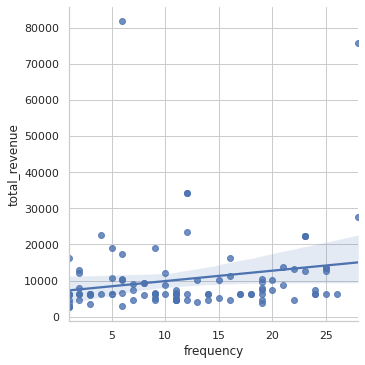

In [234]:
sns.set(style='whitegrid', rc={'figure.figsize': (10,5)})
sns.lmplot(x='frequency', y='total_revenue', data=group_a2)

In [235]:
# Предварительное заключение: фактор 'frequency' может быть интересен для дальнейшей работы.

In [236]:
#

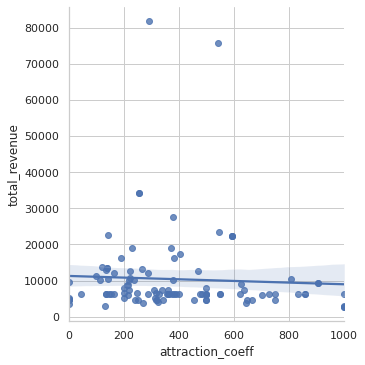

In [237]:
sns.set(style='whitegrid', rc={'figure.figsize': (10,5)})
sns.lmplot(x='attraction_coeff', y='total_revenue', data=group_a2)

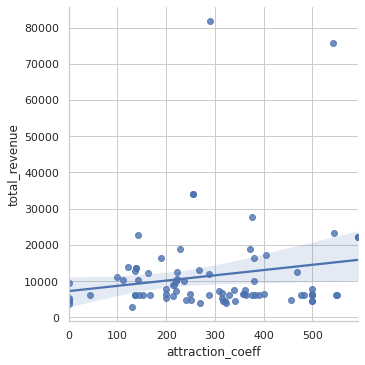

In [238]:
sns.set(style='whitegrid', rc={'figure.figsize': (10,5)})
sns.lmplot(x='attraction_coeff', y='total_revenue', data=group_a2.query('attraction_coeff <= 600'))

In [239]:
# Предварительное заключение: фактор 'attraction_coeff' может быть интересен для дальнейшей работы, если взять срез " < 600 " 

In [240]:
#

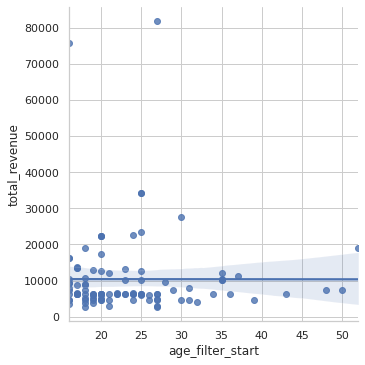

In [241]:
sns.set(style='whitegrid', rc={'figure.figsize': (10,5)})
sns.lmplot(x='age_filter_start', y='total_revenue', data=group_a2)

In [242]:
# Предварительное заключение: фактор "age_filter_start" не очень интересен для дальнейшего анализа. 

In [243]:
#

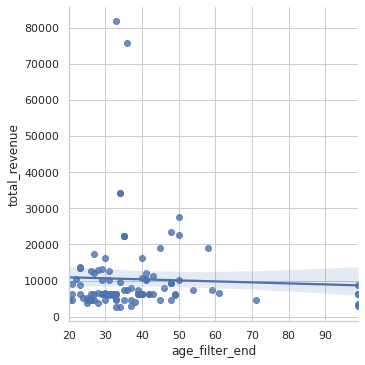

In [244]:
sns.set(style='whitegrid', rc={'figure.figsize': (10,5)})
sns.lmplot(x='age_filter_end', y='total_revenue', data=group_a2)

In [245]:
# Предварительное заключение: фактор "age_filter_end" не очень интересен для дальнейшего анализа.

In [246]:
#

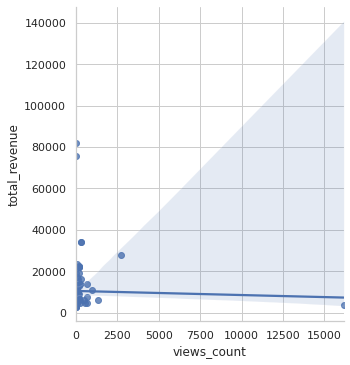

In [247]:
sns.set(style='whitegrid', rc={'figure.figsize': (10,5)})
sns.lmplot(x='views_count', y='total_revenue', data=group_a2)

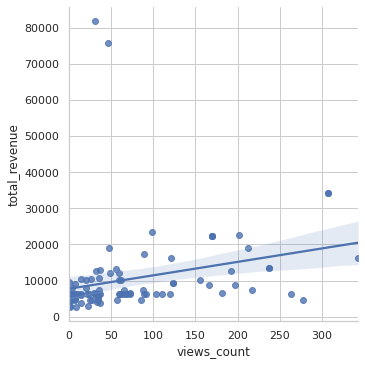

In [248]:
sns.set(style='whitegrid', rc={'figure.figsize': (10,5)})
sns.lmplot(x='views_count', y='total_revenue', data=group_a2.query('gender == 1 & views_count < 400'))

In [249]:
# Предварительное заключение: фактор 'views_count' может быть интересен для дальнейшего анализа.

In [250]:

#  Кроме того, для дальнейшей работы может быть интересен фактор 'country_x', эффективность работы с которым была доказана выше
#  (однако остается вопрос: так для каких именно стран стоит делать нововведение?)


In [251]:
#

In [252]:

#       Попробуем получить какую-то информацию, рассматривая корреляционную связь между разными факторами.
#       Коэффициент корреляции в статистическом смысле обозначает силу и характер взаимосвязи между двумя
#  количественными переменными.
#       Посмотрим коэффициенты корреляции по Пирсону и по Спирмену. Будем ориентироваться на расчеты по Спирмену (коэфф.
#  корреляции Пирсона очень чувствителен к выбросам, асимметрии, бимодальности).
#       "По Спирмену":  можем утверждать (используя градацию шкалы Чеддока), что у фактора "total_revenue_log" 
#  выявлена 'умеренная' корреляционная связь с фактором "views_count" (+0.42) (т.е. число полученных оценок у пользователей),
#  а также 'слабая' корреляционная связь с фактором "frequency" (+0.28) и age (+0.12). 
#       Интересно, что корреляционная связь с фактором "frequency" проявляется и по Спирмену, и по Пирсону.  
#       Отметим, что сила и характер взаимосвязи между исследуемыми элементами еще не обязательно говорит о причинно-
#  следственной зависимости. Но корреляция МОЖЕТ означать причинно-следственную зависимость.


In [253]:
# Формируем набор независимых переменных (НЗ)
cols_to_keep = ['age', 'attraction_coeff', 'coins', 'country_x', 'views_count', 'frequency', 'total_revenue']

In [254]:
df = group_a2[cols_to_keep]
df.head()

,age,attraction_coeff,coins,country_x,views_count,frequency,total_revenue
2,28,229,6.0,Argentina,48,9.0,18902
3,30,250,8.0,Chile,8,16.0,4732
6,40,99,8.0,Spain,994,16.0,11154
8,38,112,4.0,Switzerland,62,13.0,10192
10,34,622,8.0,France,61,25.0,6292


In [255]:
df.isnull().sum()

age                 0
attraction_coeff    0
coins               0
country_x           0
views_count         0
frequency           0
total_revenue       0
dtype: int64

In [256]:
df.dtypes

age                   int64
attraction_coeff      int64
coins               float64
country_x            object
views_count           int64
frequency           float64
total_revenue         int64
dtype: object

In [257]:
df = df.assign(total_revenue_log = np.log(df.total_revenue))
df.head()

,age,attraction_coeff,coins,country_x,views_count,frequency,total_revenue,total_revenue_log
2,28,229,6.0,Argentina,48,9.0,18902,9.847023
3,30,250,8.0,Chile,8,16.0,4732,8.462103
6,40,99,8.0,Spain,994,16.0,11154,9.319553
8,38,112,4.0,Switzerland,62,13.0,10192,9.229358
10,34,622,8.0,France,61,25.0,6292,8.747034


In [258]:
df.corr()  # по Пирсону

,age,attraction_coeff,coins,views_count,frequency,total_revenue,total_revenue_log
age,1.000000,-0.075163,0.146585,0.018831,0.111475,0.084863,0.135056
attraction_coeff,-0.075163,1.000000,-0.001156,-0.177710,-0.245521,-0.051075,-0.138971
coins,0.146585,-0.001156,1.000000,-0.019673,-0.082641,0.341583,0.350933
views_count,0.018831,-0.177710,-0.019673,1.000000,-0.063317,-0.027824,-0.075982
frequency,0.111475,-0.245521,-0.082641,-0.063317,1.000000,0.194704,0.286235
total_revenue,0.084863,-0.051075,0.341583,-0.027824,0.194704,1.000000,0.867292
total_revenue_log,0.135056,-0.138971,0.350933,-0.075982,0.286235,0.867292,1.000000


In [259]:
df.corr()['total_revenue_log'].sort_values(ascending=False).round(2)

total_revenue_log    1.00
total_revenue        0.87
coins                0.35
frequency            0.29
age                  0.14
views_count         -0.08
attraction_coeff    -0.14
Name: total_revenue_log, dtype: float64

In [260]:
df.corr(method='spearman')  # по Спирмену

,age,attraction_coeff,coins,views_count,frequency,total_revenue,total_revenue_log
age,1.000000,0.011545,-0.049351,0.359888,0.039293,0.118095,0.118095
attraction_coeff,0.011545,1.000000,0.055234,-0.196453,-0.212888,-0.129464,-0.129464
coins,-0.049351,0.055234,1.000000,-0.011183,-0.237377,-0.032003,-0.032003
views_count,0.359888,-0.196453,-0.011183,1.000000,0.271251,0.424322,0.424322
frequency,0.039293,-0.212888,-0.237377,0.271251,1.000000,0.278553,0.278553
total_revenue,0.118095,-0.129464,-0.032003,0.424322,0.278553,1.000000,1.000000
total_revenue_log,0.118095,-0.129464,-0.032003,0.424322,0.278553,1.000000,1.000000


In [261]:
df.corr(method='spearman')['total_revenue_log'].sort_values(ascending=False).round(2)

total_revenue_log    1.00
total_revenue        1.00
views_count          0.42
frequency            0.28
age                  0.12
coins               -0.03
attraction_coeff    -0.13
Name: total_revenue_log, dtype: float64

In [262]:
#                                       3.2. Основной блок аналитики

In [263]:
#                                 3.2.1. Фактор "age" (возраст пользователей)

In [264]:
# Распределим всех пользователей по возрастным группам

cut_labels = ['16-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-99']
cut_bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 99]

group_b_full = group_b_full.assign(age_diff = pd.cut(group_b_full['age'], bins=cut_bins, labels=cut_labels))
group_a1_full = group_a1_full.assign(age_diff = pd.cut(group_a1_full['age'], bins=cut_bins, labels=cut_labels))
group_a2_full = group_a2_full.assign(age_diff = pd.cut(group_a2_full['age'], bins=cut_bins, labels=cut_labels))

In [265]:
group_b_full['group'] = 'B'
group_a1_full['group'] = 'A'
group_a2_full['group'] = 'A'       

In [266]:
all_groups = pd.concat([group_b_full, group_a1_full, group_a2_full], ignore_index=True, verify_integrity=True)

In [267]:
(all_groups.country_x == all_groups.country_y).unique()

array([ True])

In [268]:
all_groups = all_groups.drop(['country_y'], axis=1)  # убираем дубликат колонки "country_x"

In [269]:
all_groups.head()

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,joined_at,paid_at,revenue,payment_id,from_page,product_type,age_diff,group
0,891345942,52,209,NaN,Italy,"1,2,3,4,5,6,8,10",1,49,55,43,...,1.0,12909,2017-05-11 13:00:00,2017-11-13 15:04:00,12909.0,147.0,trial_vip_popup,trial_premium,51-55,B
1,892054251,37,390,NaN,United States of America,"1,2,3,4,6,7",1,34,40,64,...,1.0,13923,2017-10-22 00:33:00,2017-10-30 01:37:00,13923.0,147.0,trial_vip_popup,trial_premium,36-40,B
2,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,...,1.0,95823,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,21-25,B
3,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,...,1.0,95823,2017-10-18 01:09:00,2017-10-27 22:38:00,3783.0,67.0,menu,other_type,21-25,B
4,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,...,1.0,95823,2017-10-18 01:09:00,2017-10-22 22:08:00,1261.0,19.0,empty_likes,coins,21-25,B


In [270]:
work_with_age = pd.DataFrame(columns=['group_test', 'group_control', 'age_diff', 'p_alpha', 'p_value', 'result'])

answer = ["Отвергаем гипотезу H(0)", "Не можем отвергнуть гипотезу H(0)"]

for i in all_groups['age_diff'].unique():
    
    s1 = all_groups.query('group == "B" & age_diff in @i')['total_revenue']
    s2 = all_groups.query('group != "B" & age_diff in @i')['total_revenue']
    
    p_value_result = mannwhitneyu(s1, s2)[1]
    
    new_row = {'group_test': 'B',
               'group_control': 'A',
               'age_diff': i,
               'p_alpha': 0.05 / ((len(cut_labels) * (len(cut_labels)-1)) / 2),  # we would do it using Bonferroni correction
               'p_value': p_value_result,
               'result': answer[p_value_result >= (0.05 / ((len(cut_labels) * (len(cut_labels)-1)) / 2))]}
    
    work_with_age = work_with_age.append([new_row])

work_with_age

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


,group_test,group_control,age_diff,p_alpha,p_value,result
0,B,A,51-55,0.001389,0.042277,Не можем отвергнуть гипотезу H(0)
0,B,A,36-40,0.001389,0.288107,Не можем отвергнуть гипотезу H(0)
0,B,A,21-25,0.001389,0.013735,Не можем отвергнуть гипотезу H(0)
0,B,A,26-30,0.001389,0.003344,Не можем отвергнуть гипотезу H(0)
0,B,A,46-50,0.001389,0.490425,Не можем отвергнуть гипотезу H(0)
0,B,A,31-35,0.001389,0.027075,Не можем отвергнуть гипотезу H(0)
0,B,A,41-45,0.001389,0.169787,Не можем отвергнуть гипотезу H(0)
0,B,A,16-20,0.001389,0.000657,Отвергаем гипотезу H(0)
0,B,A,56-99,0.001389,0.000058,Отвергаем гипотезу H(0)


In [271]:

#    Вывод: отвергнута гипотеза H(0) в отношении групп пользователей 16-20 лет, 56-99 лет (фактор "age"), что позволяет нам  
# говорить о статистически значимых различиях между тестовой группой В и контрольной A1+A2 по метрике 'total_revenue' (у 
# пользователей 16-20, 56-99 лет).


In [272]:
#                                     3.2.2. Фактор "country" (страна пользователя)

In [273]:
group_b.country_x.unique()  # будем ориентироваться на список стран из тестовой (экспериментальной) группы "В"

array(['United States of America', 'Canada', 'Spain', 'Latvia', 'Italy',
       'United Kingdom (Great Britain)', 'France', 'Argentina',
       'United Arab Emirates', 'Chile', 'Israel', 'Australia', 'Mexico',
       'Germany', 'Turkey', 'Belgium'], dtype=object)

In [274]:
group_b.country_x.nunique()

16

In [275]:
all_groups.query('group == "B" & product_type == "premium_no_trial"').country_x.unique()  # хорошо, то же самое что в группе "В"

array(['United States of America', 'Canada', 'Spain', 'Latvia', 'Italy',
       'United Kingdom (Great Britain)', 'France', 'Argentina',
       'United Arab Emirates', 'Chile', 'Israel', 'Australia', 'Mexico',
       'Germany', 'Turkey', 'Belgium'], dtype=object)

In [276]:
all_groups.query('group != "B" & product_type == "premium_no_trial"').country_x.unique()

array(['Italy', 'France', 'United States of America', 'India', 'Chile',
       'Israel', 'United Arab Emirates', 'United Kingdom (Great Britain)',
       'Argentina', 'Switzerland', 'Australia', 'Turkey', 'Germany',
       'Spain', 'Portugal', 'Canada', 'Belgium', 'Ukraine', 'Austria'],
      dtype=object)

In [277]:
all_groups.country_x.isin(['United States of America', 'Canada', 'Spain', 'Latvia', 'Italy',
       'United Kingdom (Great Britain)', 'France', 'Argentina',
       'United Arab Emirates', 'Chile', 'Israel', 'Australia', 'Mexico',
       'Germany', 'Turkey', 'Belgium']).value_counts()

True     938
False     40
Name: country_x, dtype: int64

In [278]:
new_list = all_groups.country_x.isin(['United States of America', 'Canada', 'Spain', 'Latvia', 'Italy',
       'United Kingdom (Great Britain)', 'France', 'Argentina',
       'United Arab Emirates', 'Chile', 'Israel', 'Australia', 'Mexico',
       'Germany', 'Turkey', 'Belgium'])

In [279]:
all_groups_0 = all_groups[new_list]
all_groups_0.head() 

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,joined_at,paid_at,revenue,payment_id,from_page,product_type,age_diff,group
0,891345942,52,209,NaN,Italy,"1,2,3,4,5,6,8,10",1,49,55,43,...,1.0,12909,2017-05-11 13:00:00,2017-11-13 15:04:00,12909.0,147.0,trial_vip_popup,trial_premium,51-55,B
1,892054251,37,390,NaN,United States of America,"1,2,3,4,6,7",1,34,40,64,...,1.0,13923,2017-10-22 00:33:00,2017-10-30 01:37:00,13923.0,147.0,trial_vip_popup,trial_premium,36-40,B
2,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,...,1.0,95823,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,21-25,B
3,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,...,1.0,95823,2017-10-18 01:09:00,2017-10-27 22:38:00,3783.0,67.0,menu,other_type,21-25,B
4,892236423,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,...,1.0,95823,2017-10-18 01:09:00,2017-10-22 22:08:00,1261.0,19.0,empty_likes,coins,21-25,B


In [280]:
group_b.country_x.value_counts()

United States of America          20
Italy                              8
France                             6
United Arab Emirates               6
Spain                              6
Chile                              6
United Kingdom (Great Britain)     5
Canada                             4
Argentina                          4
Israel                             2
Germany                            2
Belgium                            1
Mexico                             1
Australia                          1
Latvia                             1
Turkey                             1
Name: country_x, dtype: int64

In [281]:
# Исключим из списка стран также те, от которых только по 1 представителю - вряд ли корректно делать выводы на основе 1 наблюдения

all_groups_0 = all_groups_0.query('country_x != "Latvia" & country_x != "Australia" & country_x != "Mexico" & country_x != "Turkey" & country_x != "Belgium"')

In [282]:
work_with_country = pd.DataFrame(columns=['group_test', 'group_control', 'country', 'p_alpha', 'p_value', 'result'])

answer = ["Отвергаем гипотезу H(0)", "Не можем отвергнуть гипотезу H(0)"]

for i in all_groups_0['country_x'].unique():
    
    s1 = all_groups_0.query('group == "B" & country_x in @i & product_type == "premium_no_trial"')['total_revenue']
    s2 = all_groups_0.query('group != "B" & country_x in @i & product_type == "premium_no_trial"')['total_revenue']
    
    p_value_result = mannwhitneyu(s1, s2)[1]
    
    new_row = {'group_test': 'B',
               'group_control': 'A',
               'country': i,
               'p_alpha': 0.05 / group_b.country_x.nunique(),  # we would do it using Bonferroni correction
               'p_value': p_value_result,
               'result': answer[p_value_result >= (0.05 / group_b.country_x.nunique())]}
    
    work_with_country = work_with_country.append([new_row])

work_with_country

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


,group_test,group_control,country,p_alpha,p_value,result
0,B,A,Italy,0.000909,0.384920,Не можем отвергнуть гипотезу H(0)
0,B,A,United States of America,0.000909,0.000625,Отвергаем гипотезу H(0)
0,B,A,Canada,0.000909,0.108400,Не можем отвергнуть гипотезу H(0)
0,B,A,Spain,0.000909,0.369220,Не можем отвергнуть гипотезу H(0)
0,B,A,United Arab Emirates,0.000909,0.240133,Не можем отвергнуть гипотезу H(0)
0,B,A,Argentina,0.000909,0.336266,Не можем отвергнуть гипотезу H(0)
0,B,A,France,0.000909,0.007550,Не можем отвергнуть гипотезу H(0)
0,B,A,United Kingdom (Great Britain),0.000909,0.215265,Не можем отвергнуть гипотезу H(0)
0,B,A,Israel,0.000909,0.015884,Не можем отвергнуть гипотезу H(0)
0,B,A,Germany,0.000909,0.187884,Не можем отвергнуть гипотезу H(0)


In [283]:

#    Вывод: отвергнута гипотеза H(0) в отношении группы пользователей из страны "United States of America" (фактор "country"),
# что позволяет нам говорить о статистически значимых различиях (по метрике 'total_revenue') между пользователями из 
# тестовой группы В и контрольной A1+A2 (из страны "United States of America").


In [284]:

# Далее прибегнем к ANOVA. Дисперсии внутри наших групп должны быть примерно одинаковы, проверим это с помощью критерия Левена. 
# Видим, что p>0.05, гипотезу H(0) отклонить не можем, дисперсия гомогенна в каждой из групп.
# Размеры выборок достаточно велики (рассматриваем все типы подписки), применение дисперсионного анализа возможно. 


In [285]:
k = all_groups.query('group == "A"').total_revenue
l = all_groups.query('group == "B"').total_revenue

In [286]:
stats.levene(k, l)

LeveneResult(statistic=3.7812031130429204, pvalue=0.05211836495063842)

In [287]:
#                                      3.2.3. Фактор "views_count" (число полученных оценок)

In [288]:
all_groups_1 = all_groups.query('gender == 1 & views_count < 400')

In [289]:
all_groups_1.views_count.quantile(q=[.33, .66])

0.33     32.0
0.66    112.0
Name: views_count, dtype: float64

In [290]:
all_groups_1.views_count.describe()

count    829.000000
mean      94.067551
std       88.761229
min        0.000000
25%       21.000000
50%       63.000000
75%      150.000000
max      364.000000
Name: views_count, dtype: float64

In [291]:
all_groups_1.groupby(['group', 'views_count'], as_index=False).agg({'total_revenue': 'mean'})

,group,views_count,total_revenue
0,A,0,7209.647059
1,A,1,9725.444444
2,A,2,8928.523810
3,A,3,8784.750000
4,A,4,13879.125000
...,...,...,...
232,B,251,30459.000000
233,B,263,17758.000000
234,B,269,3835.000000
235,B,287,129870.000000


In [292]:
df_1 = all_groups_1.groupby(['group', 'views_count'], as_index=False).agg({'total_revenue': 'mean'})

In [293]:
cut_labels_1 = ['0-32', '33-112', '113-364']
cut_bins_1 = [-1, 32, 112, 364]

df_1 = df_1.assign(views_count_diff = pd.cut(df_1['views_count'], bins=cut_bins_1, labels=cut_labels_1))

In [294]:
formula = 'total_revenue ~ group + views_count_diff + group:views_count_diff'
model = ols(formula, df_1).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

                              sum_sq     df         F    PR(>F)
group                   1.739626e+09    1.0  9.428346  0.002392
views_count_diff        2.550118e+09    2.0  6.910508  0.001217
group:views_count_diff  6.131248e+08    2.0  1.661493  0.192116
Residual                4.262185e+10  231.0       NaN       NaN


In [295]:
# Как видим, эффект от влияния обоих факторов на ЗП ('total_revenue') является статистически значимым (в отличии от их взаимодействия)

In [296]:
df_1.views_count_diff = df_1.views_count_diff.astype(object)

In [297]:
df_1['combination'] = df_1['group'] + ' \ ' + df_1['views_count_diff'] 

In [298]:
print(pairwise_tukeyhsd(df_1['total_revenue'], groups=df_1['combination']).summary())

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
   group1      group2    meandiff  p-adj     lower      upper    reject
-----------------------------------------------------------------------
   A \ 0-32 A \ 113-364  4888.0066  0.563  -3678.6025 13454.6157  False
   A \ 0-32  A \ 33-112   1808.236    0.9  -6758.3731 10374.8451  False
   A \ 0-32    B \ 0-32  2084.6633    0.9   -8387.581 12556.9077  False
   A \ 0-32 B \ 113-364 14473.7228  0.001   5127.0698 23820.3758   True
   A \ 0-32  B \ 33-112  5313.6041 0.6065   -4450.156 15077.3642  False
A \ 113-364  A \ 33-112 -3079.7706 0.8154 -10456.8748  4297.3335  False
A \ 113-364    B \ 0-32 -2803.3433    0.9 -12327.1438  6720.4572  False
A \ 113-364 B \ 113-364  9585.7162 0.0128   1315.6016 17855.8308   True
A \ 113-364  B \ 33-112   425.5975    0.9  -8313.1602  9164.3551  False
 A \ 33-112    B \ 0-32   276.4273    0.9  -9247.3732  9800.2278  False
 A \ 33-112 B \ 113-364 12665.4868  0.001   4395.3722 20935.6014

In [299]:

# ВЫВОД: видим, что гипотезы H(0) были отклонены при сравнении средних значений в парах A\0-32 и B\113-364,
# A\113-364 и B\113-364, A\33-112 и B\113-364, A\33-112 и B\113-364, B\0-32 и B\113-364, что позволяет нам говорить о
# статистически значимых различиях (по метрике 'total_revenue') между пользователями из тестовой группы В и
# контрольной A1+A2 (показатели статистически значимо увеличились).   


In [300]:
# Проверим, что получим при использовании непараметрических тестов (Kruskal-Wallis Test)

data1 = df_1.query('group == "A" & views_count_diff == "0-32"').total_revenue 
data2 = df_1.query('group == "A" & views_count_diff == "33-112"').total_revenue
data3 = df_1.query('group == "A" & views_count_diff == "113-364"').total_revenue

data4 = df_1.query('group == "B" & views_count_diff == "0-32"').total_revenue 
data5 = df_1.query('group == "B" & views_count_diff == "33-112"').total_revenue
data6 = df_1.query('group == "B" & views_count_diff == "113-364"').total_revenue

In [301]:
stat, p = kruskal(data1, data2, data3, data4, data5, data6)
print('Statistics=%.3f, p=%.3f' % (stat, p)) #  отвергли гипотезу H(0)

Statistics=21.067, p=0.001


In [302]:
data = [data1, data2, data3, data4, data5, data6]

sp.posthoc_dunn(data, p_adjust = 'bonferroni') #  perform Dunn's test using a Bonferonni correction for the p-values

,1,2,3,4,5,6
1,1.000000,1.000000,0.503727,1.000000,0.081308,0.000710
2,1.000000,1.000000,1.000000,1.000000,0.674851,0.008953
3,0.503727,1.000000,1.000000,1.000000,1.000000,0.248219
4,1.000000,1.000000,1.000000,1.000000,1.000000,0.499994
5,0.081308,0.674851,1.000000,1.000000,1.000000,1.000000
6,0.000710,0.008953,0.248219,0.499994,1.000000,1.000000


In [303]:
sp.posthoc_dunn(data, p_adjust = 'holm') #  perform Dunn's test using a Holm correction for the p-values

,1,2,3,4,5,6
1,1.000000,1.000000,0.366662,0.965402,0.070467,0.000710
2,1.000000,1.000000,1.000000,1.000000,0.404910,0.008357
3,0.366662,1.000000,1.000000,1.000000,1.000000,0.198576
4,0.965402,1.000000,1.000000,1.000000,1.000000,0.366662
5,0.070467,0.404910,1.000000,1.000000,1.000000,1.000000
6,0.000710,0.008357,0.198576,0.366662,1.000000,1.000000


In [304]:

# ВЫВОД: видим, что при использовании непараметрических Kruskal-Wallis test и Dunn test, гипотезы H(0) были отклонены при
# сравнении значений в парах A\0-32 и B\113-364, A\33-112 и B\113-364, что позволяет нам говорить о статистически значимых
# различиях (по метрике 'total_revenue') между пользователями из тестовой группы В и контрольной A1+A2. 

# Интресно, что и с поправкой Бонферрони, и с более "мягкой" поправкой Холма получаем одинаковые конечные результаты.

# Принимаем решение в конечных выводах опираться на "непараметрику" (учитывая более строгий характер поправки Бонферрони;
# учитывая характеристики исходных групп). 


In [305]:
#                                   3.2.4. Фактор "attraction_coeff" (коэффициент привлекательности)

In [306]:
all_groups_2 = all_groups.query('attraction_coeff < 600')

In [307]:
all_groups_2.attraction_coeff.quantile([.33, .66])

0.33    199.08
0.66    328.16
Name: attraction_coeff, dtype: float64

In [308]:
all_groups_2.attraction_coeff.describe()

count    877.000000
mean     273.316990
std      148.372025
min        0.000000
25%      175.000000
50%      261.000000
75%      376.000000
max      594.000000
Name: attraction_coeff, dtype: float64

In [309]:
all_groups_2.groupby(['group', 'attraction_coeff'], as_index=False).agg({'total_revenue': 'mean'})

,group,attraction_coeff,total_revenue
0,A,0,8401.872340
1,A,4,26.000000
2,A,37,10075.000000
3,A,41,11102.000000
4,A,43,10439.000000
...,...,...,...
287,B,541,4719.000000
288,B,547,27404.000000
289,B,552,25207.000000
290,B,555,14352.000000


In [310]:
df_2 = all_groups_2.groupby(['group', 'attraction_coeff'], as_index=False).agg({'total_revenue': 'mean'})

In [311]:
cut_labels_2 = ['0-199', '200-328', '329-594']
cut_bins_2 = [-1, 199, 328, 594]

df_2 = df_2.assign(attraction_coeff_diff = pd.cut(df_2['attraction_coeff'], bins=cut_bins_2, labels=cut_labels_2))

In [312]:
formula = 'total_revenue ~ group + attraction_coeff_diff + group:attraction_coeff_diff'

model = ols(formula, df_2).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

                                   sum_sq     df         F    PR(>F)
group                        1.223206e+09    1.0  1.225194  0.269274
attraction_coeff_diff        2.302750e+09    2.0  1.153247  0.317074
group:attraction_coeff_diff  3.824222e+09    2.0  1.915219  0.149194
Residual                     2.855359e+11  286.0       NaN       NaN


In [313]:

# ВЫВОД: Как видим, эффект от влияния обоих факторов на ЗП ('total_revenue') статистически незначим (как и их взаимодействие) 


In [314]:
# Проверим, что получим при использовании непараметрических тестов (Kruskal-Wallis Test)

data_1 = df_2.query('group == "A" & attraction_coeff_diff == "0-199"').total_revenue 
data_2 = df_2.query('group == "A" & attraction_coeff_diff == "200-328"').total_revenue
data_3 = df_2.query('group == "A" & attraction_coeff_diff == "329-594"').total_revenue

data_4 = df_2.query('group == "B" & attraction_coeff_diff == "0-199"').total_revenue 
data_5 = df_2.query('group == "B" & attraction_coeff_diff == "200-328"').total_revenue
data_6 = df_2.query('group == "B" & attraction_coeff_diff == "329-594"').total_revenue

In [315]:
stat, p = kruskal(data_1, data_2, data_3, data_4, data_5, data_6)
print('Statistics=%.3f, p=%.3f' % (stat, p))  # отвергли гипотезу H(0)

Statistics=18.410, p=0.002


In [316]:
data_att_coef = [data_1, data_2, data_3, data_4, data_5, data_6]

sp.posthoc_dunn(data_att_coef, p_adjust = 'bonferroni')  # perform Dunn's test using a Bonferonni correction for the p-values

,1,2,3,4,5,6
1,1.000000,1.000000,1.000000,0.782614,0.071756,1.00000
2,1.000000,1.000000,1.000000,0.366086,0.021985,1.00000
3,1.000000,1.000000,1.000000,0.131010,0.005218,1.00000
4,0.782614,0.366086,0.131010,1.000000,1.000000,1.00000
5,0.071756,0.021985,0.005218,1.000000,1.000000,0.56119
6,1.000000,1.000000,1.000000,1.000000,0.561190,1.00000


In [317]:
sp.posthoc_dunn(data_att_coef, p_adjust = 'holm')  # perform Dunn's test using a Holm correction for the p-values

,1,2,3,4,5,6
1,1.000000,1.000000,1.000000,0.469568,0.062188,1.000000
2,1.000000,1.000000,1.000000,0.268463,0.020519,1.000000
3,1.000000,1.000000,1.000000,0.104808,0.005218,1.000000
4,0.469568,0.268463,0.104808,1.000000,1.000000,1.000000
5,0.062188,0.020519,0.005218,1.000000,1.000000,0.374126
6,1.000000,1.000000,1.000000,1.000000,0.374126,1.000000


In [318]:

# ВЫВОД: видим, что при использовании непараметрических Kruskal-Wallis test и Dunn test, гипотезы H(0) были отклонены при
# сравнении значений в парах A\200-328 и B\200-328, A\329-594 и B\200-328, что позволяет нам говорить о статистически значимых
# различиях (по метрике 'total_revenue') между пользователями из тестовой группы В и контрольной A1+A2. 

# И с поправкой Бонферрони, и с более "мягкой" поправкой Холма получаем одинаковые конечные результаты.

# Принимаем решение в конечных выводах опираться на "непараметрику" (учитывая более строгий характер поправки Бонферрони;
# учитывая характеристики исходных групп). 


In [319]:
#                               3.2.5. Фактор "frequency" (частота посещений сайта)

In [320]:
all_groups['frequency'] = (all_groups['visit_days'].str.count(',') + 1)  # создаем новую колонку "frequency"

In [321]:
all_groups = all_groups.fillna({'frequency': all_groups.frequency.median()})  # убираем NaN в 'frequency'

In [322]:
df_3 = all_groups.groupby(['group', 'frequency'], as_index=False).agg({'total_revenue': 'mean'})

In [323]:
cut_labels_3 = ['1-10', '11-20', '21-31']
cut_bins_3 = [0, 10, 20, 31]

df_3 = df_3.assign(frequency_diff = pd.cut(df_3['frequency'], bins=cut_bins_3, labels=cut_labels_3))

In [324]:
df_3 = df_3.drop(columns='frequency')

In [325]:
formula = 'total_revenue ~ group + frequency_diff + group:frequency_diff'
model = ols(formula, df_3).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

                            sum_sq    df         F    PR(>F)
group                 3.198248e+07   1.0  0.023153  0.879649
frequency_diff        1.896957e+09   2.0  0.686623  0.507777
group:frequency_diff  1.841123e+09   2.0  0.666413  0.517878
Residual              7.183112e+10  52.0       NaN       NaN


In [326]:

# ВЫВОД:  Как видим, эффект от влияния обоих факторов на ЗП ('total_revenue') статистически незначим (как и их взаимодействие) 


In [327]:
# Проверим, что получим при использовании непараметрических тестов (Kruskal-Wallis Test)

data_3_1 = df_3.query('group == "A" & frequency_diff == "1-10"').total_revenue 
data_3_2 = df_3.query('group == "A" & frequency_diff == "11-20"').total_revenue
data_3_3 = df_3.query('group == "A" & frequency_diff == "21-31"').total_revenue

data_3_4 = df_3.query('group == "B" & frequency_diff == "1-10"').total_revenue 
data_3_5 = df_3.query('group == "B" & frequency_diff == "11-20"').total_revenue
data_3_6 = df_3.query('group == "B" & frequency_diff == "21-31"').total_revenue

In [328]:
stat, p = kruskal(data_3_1, data_3_2, data_3_3, data_3_4, data_3_5, data_3_6)
print('Statistics=%.3f, p=%.3f' % (stat, p)) # не можем отвергнуть гипотезу H(0)

Statistics=5.823, p=0.324


In [329]:

# ВЫВОД: при использовании непараметрического Kruskal-Wallis test не можем отвергнуть гипотезу H(0),
# нет статистически значимых различий (по метрике 'total_revenue') между пользователями из тестовой группы В и контрольной A1+A2.


In [330]:
#                                             4. ОБЩИЕ ВЫВОДЫ ПО ПРОЕКТУ

In [331]:

# 1.   Можем констатировать, что эксперимент в целом был успешен. Тем не менее, есть вопросы к чистоте планирования
#  эксперимента (некорректное сплитование на группы), что может поставить под вопрос ценность полученных данных.
#      Проанализировав некоторыё основные метрики (Revenue, ARPPU, Active Users) можно увидеть, что за период эксперимента
#  в тестовой группе "В" размер Revenue стал несколько меньше, чем в группе "А1", но больше чем в "А2";  
#  количество Active Users в тестовой группе "В" упало по сравнению с "А1" и "А2" (можно предположить, что они ушли с
#  премиум-подписки в связи с изменившимися тарифами); в то же время за счет изменения стоимости премиум-подписки и
#  сокращения числа пользователей, в тестовой группе "В", по сравнению с группами "А1" и "А2", ощутимо выросла метрика ARPPU. 


In [332]:

# 2.  Были получены статистически значимые результаты, позволяющие утверждать,что нововведение имеет смысл среди
#  следующих конкретных групп пользователей:   
#     - пользователи возрастной категории 16-20 лет, 56-99 лет;
#     - пользователи из United States of America;
#     - пользователи с показателем "views_count" (от 113 до 364 единиц);
#     - пользователи с показателем "attraction_coeff" (от 200 до 328 единиц). 
